<a href="https://colab.research.google.com/github/austinmcdannald/feasst/blob/main/Active_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up Python Environment

In [1]:
!pip install gpflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 445 kB 4.0 MB/s 
     |████████████████████████████████| 107 kB 40.6 MB/s 


In [2]:
import numpy as np
import tensorflow as tf
import gpflow
from matplotlib import pyplot as plt
import pandas as pd

np.random.seed(12)
tf.random.set_seed(12)

/usr/local/lib/python3.7/dist-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
/usr/local/lib/python3.7/dist-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."


# Set up the Ground Truth
(This is what we will try to learn by Active Learning)


In [ ]:
#Set up a function that gives us some property from a 1D input
def ground_truth_function(x):
    y =    np.sin(np.pi*x/50)\
        +3*np.sin(np.pi*x/100)\
        +1*np.sin(np.pi*(x+3)/10)
    return y

In [ ]:
#Set up the Domain (i.e. inputs)
x_ground_truth = np.linspace(0,100,1001)
x_test = x_ground_truth

#Calcualte the Ground Truth
y_ground_truth = ground_truth_function(x_ground_truth)    

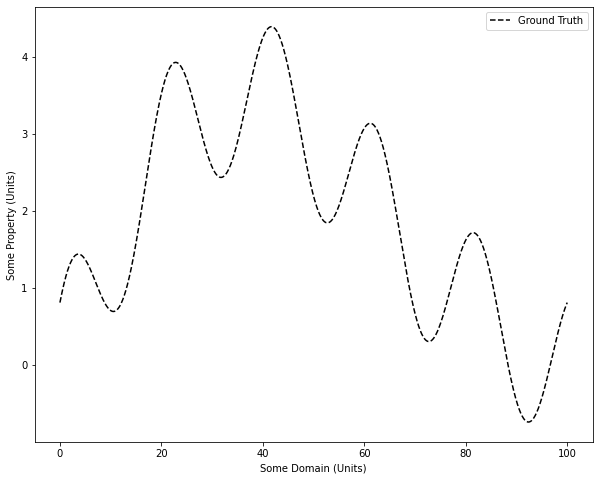

In [ ]:
#plot that function
plt.figure(figsize = (10,8))
plt.plot(x_ground_truth,y_ground_truth, "k--", label = "Ground Truth")
plt.xlabel("Some Domain (Units)")
plt.ylabel("Some Property (Units)")
plt.legend()
plt.show()

In [ ]:
def measure(x, std_noise = 0.25):
    #Find the ground truth, and add Gaussian noise (defined by mean and std)
    y = ground_truth_function(x) + np.random.normal(loc= 0, scale = std_noise, size = x.shape) 
    
    #Find the uncertainty in the measurement
    y_uncertainty = std_noise
    return y, y_uncertainty

# Pick random starting measurements and regress with GPR

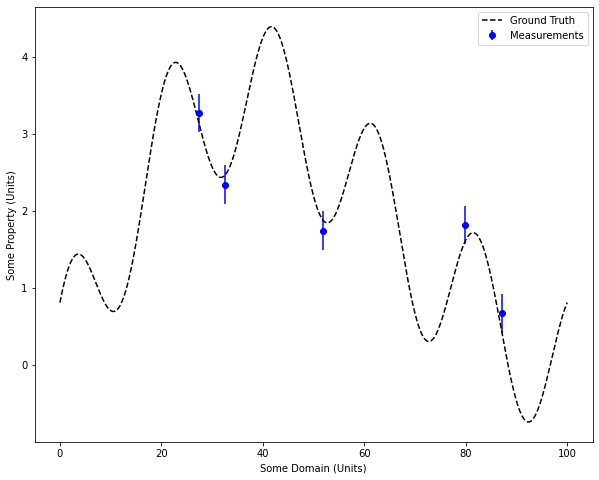

In [ ]:
starting_measurements = 5

x_starting = np.random.permutation(x_test)[:5]
x_measured = x_starting
y_measured, y_measured_err = measure(x_measured)

#Plot the measurements alongside the ground truth
plt.figure(figsize = (10,8))
plt.errorbar(x_measured, y_measured, y_measured_err, fmt = "bo", label = "Measurements")
plt.plot(x_ground_truth,y_ground_truth, "k--", label = "Ground Truth")
plt.xlabel("Some Domain (Units)")
plt.ylabel("Some Property (Units)")
plt.legend()
plt.show()

In [ ]:
def Train_GPR(training_x, training_y):
  #Define the model
  K = gpflow.kernels.RBF(variance=5, lengthscales=10)

  data = (tf.convert_to_tensor(training_x.reshape(-1,1)),
          tf.convert_to_tensor(training_y.reshape(-1,1)))
  model = gpflow.models.GPR(data = data, 
                            kernel = K, 
                            mean_function=None, 
                            noise_variance= 1.0)

  opt = gpflow.optimizers.Scipy()
  
  
  #Train the Model on the data
  opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000))
  return model
  

/usr/local/lib/python3.7/dist-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."


[]

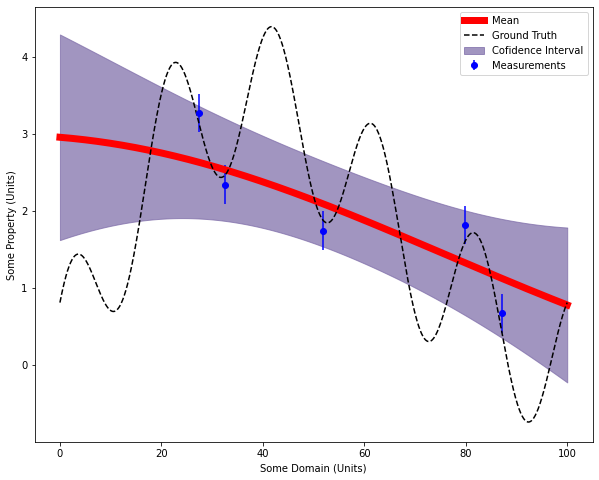

In [ ]:
#Train Model on Measured Data
model = Train_GPR(x_measured, y_measured)

#Predict on ALL x locations:
mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

#plot
plt.figure(figsize=(10,8))
plt.plot(x_test, mean, "r-", linewidth=7.0, label = 'Mean')
plt.fill_between(tf.reshape(x_test, -1), 
                 tf.reshape(mean, -1) +1.96*np.sqrt(var[:,0]), 
                 tf.reshape(mean, -1) -1.96*np.sqrt(var[:,0]), 
                 alpha=0.7, color="#7A68A6", label = 'Cofidence Interval')
plt.errorbar(x_measured, y_measured, y_measured_err, fmt = "bo", label = "Measurements")
plt.plot(x_ground_truth,y_ground_truth, "k--", label = "Ground Truth")
plt.xlabel("Some Domain (Units)")
plt.ylabel("Some Property (Units)")
plt.legend()
plt.plot()

#Active Learning Decision Making Policies

In [ ]:
AL_loops = 15

#Pure Explore

What if your goal is to discover the function with high confidence everywhere in the domain? Try pure explore!

In [ ]:
def pure_explore(mean, var):
  next = np.argmax(var)
  return next

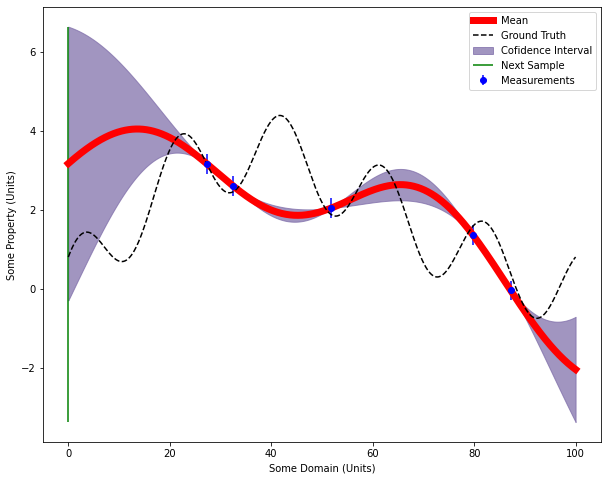

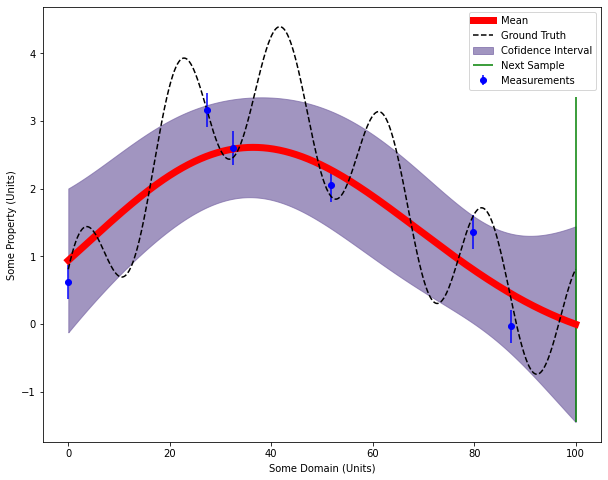

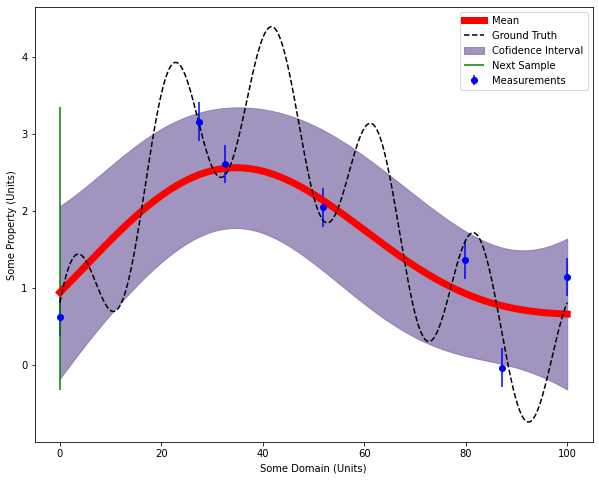

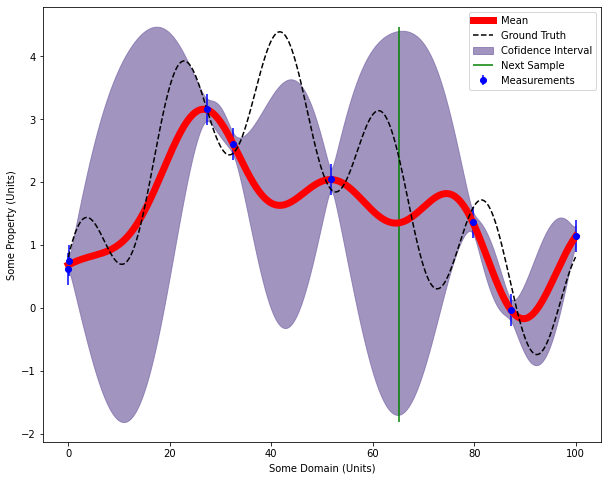

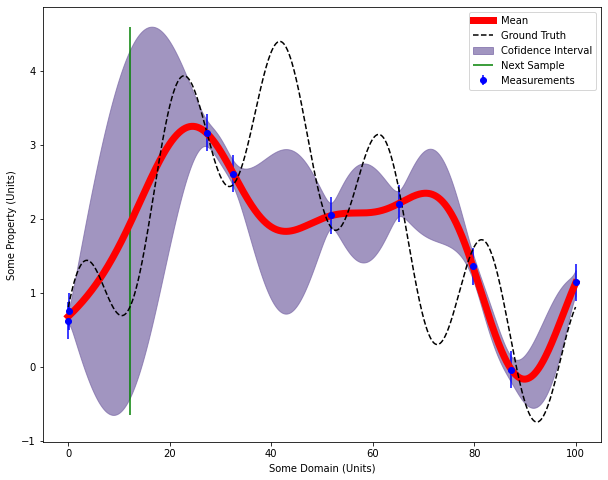

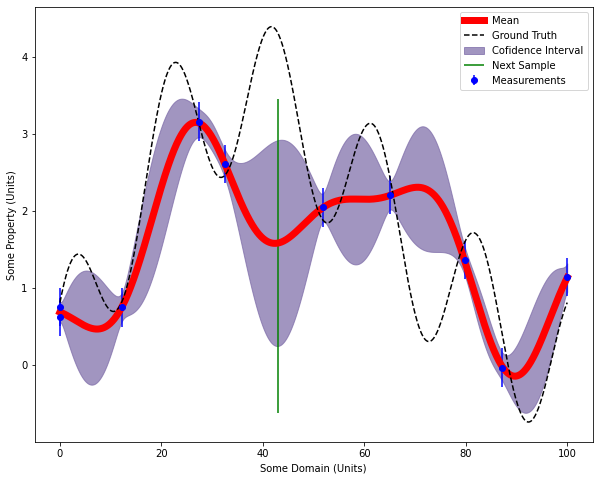

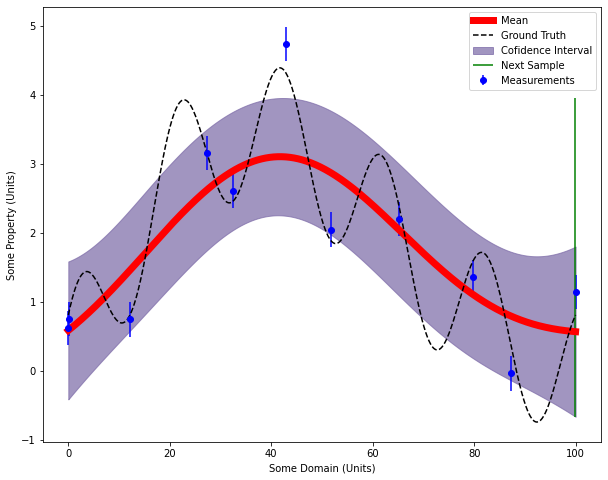

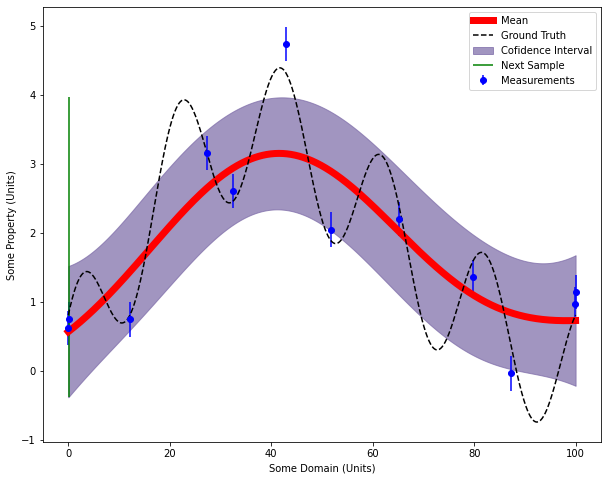

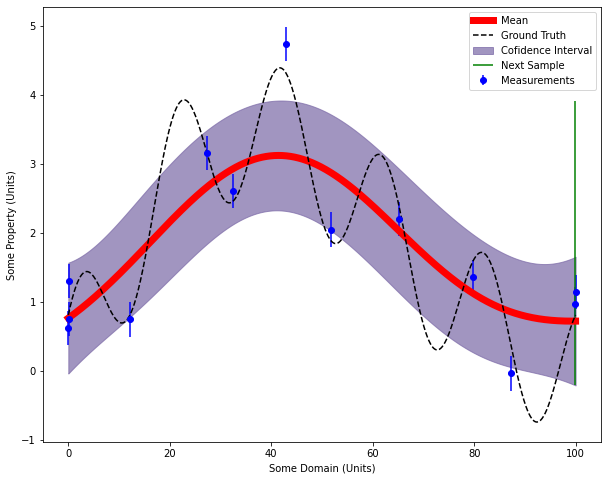

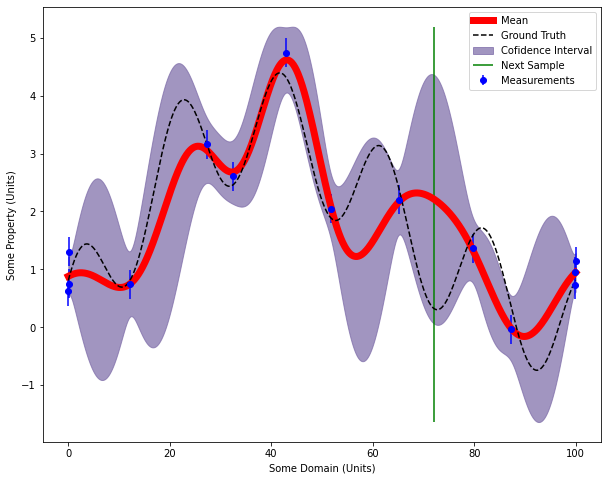

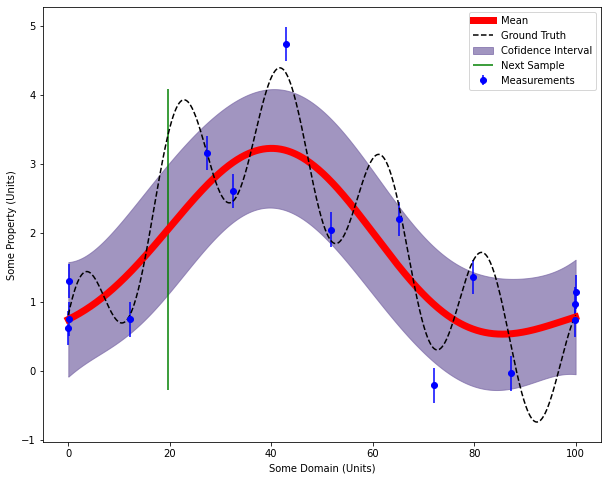

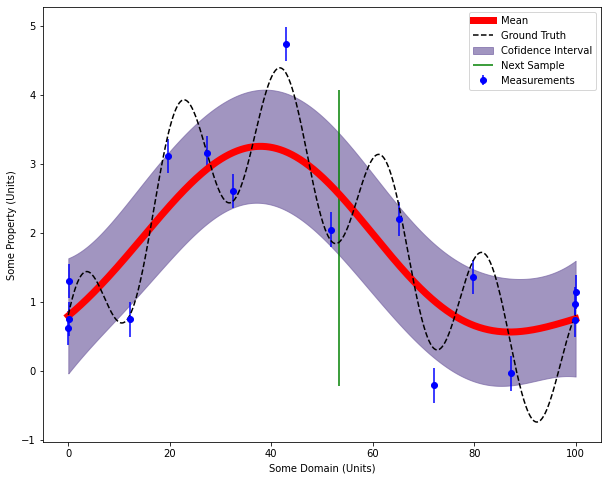

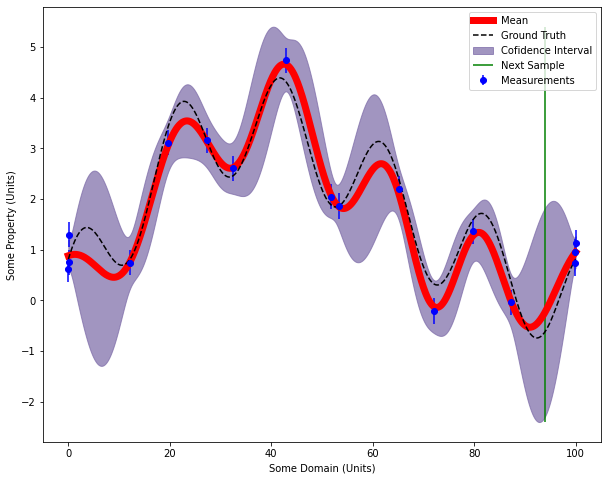

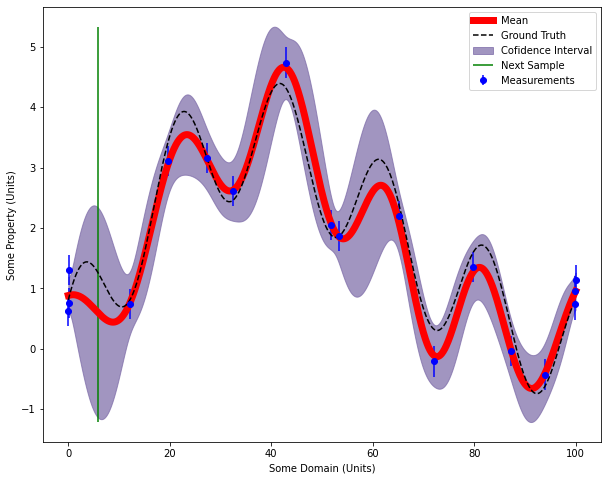

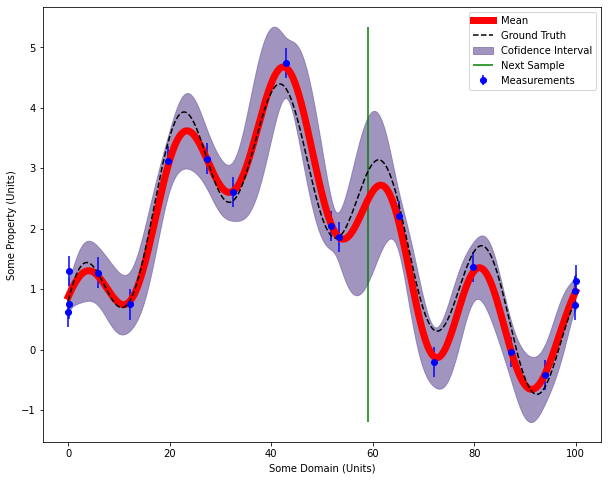

In [ ]:
#Initialize:
x_measured = x_starting
y_measured, y_measured_err = measure(x_measured)

#Active Learning Loops
for i in range(AL_loops):
  #Use a GP to analyze current data:
  model = Train_GPR(x_measured, y_measured)

  #Predict on ALL x locations:
  mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

  #Predict on unmeasured x locations:
  x_unmeasured = np.setdiff1d(x_test, x_measured)
  mean_unmeasured, var_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)))

  #Choose the next measurement:
  next = pure_explore(mean_unmeasured, var_unmeasured)
  x_next = x_unmeasured[next]  
  
  #plot
  y_upperbound = tf.reshape(mean, -1) +1.96*np.sqrt(var[:,0])
  y_lowerbound = tf.reshape(mean, -1) -1.96*np.sqrt(var[:,0])
  plt.figure(figsize=(10,8))
  plt.plot(x_test, mean, "r-", linewidth=7.0, label = 'Mean')
  plt.fill_between(tf.reshape(x_test, -1), 
                   y_upperbound, 
                   y_lowerbound, 
                   alpha=0.7, color="#7A68A6", label = 'Cofidence Interval')
  plt.errorbar(x_measured, y_measured, y_measured_err, fmt = "bo", label = "Measurements")
  plt.plot(x_ground_truth,y_ground_truth, "k--", label = "Ground Truth")
  plt.vlines(x_next, ymin= np.min(y_lowerbound), ymax = np.max(y_upperbound), colors='g', label = 'Next Sample')
  plt.xlabel("Some Domain (Units)")
  plt.ylabel("Some Property (Units)")
  plt.legend()
  plt.plot()  
  plt.show()

  #Measure the new locations and add that to the training data
  y_next, y_next_err = measure(x_next)
  y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
  x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
  

## Pure Exploit

In [ ]:
def pure_exploit(mean, var):
  next = np.argmax(mean)
  return next

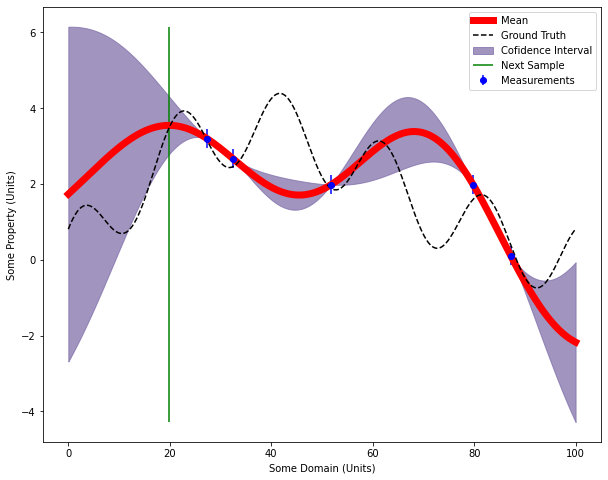

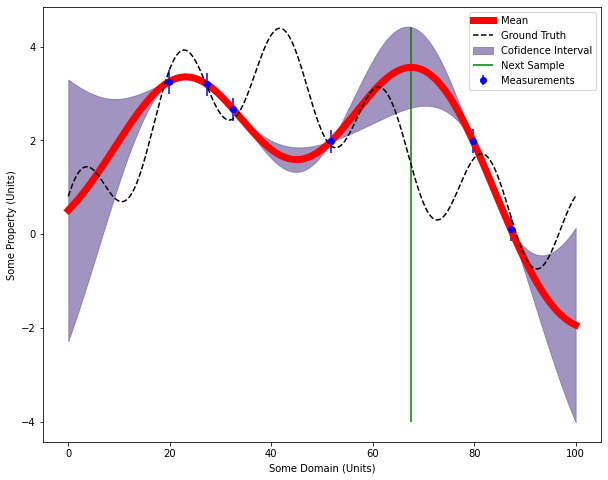

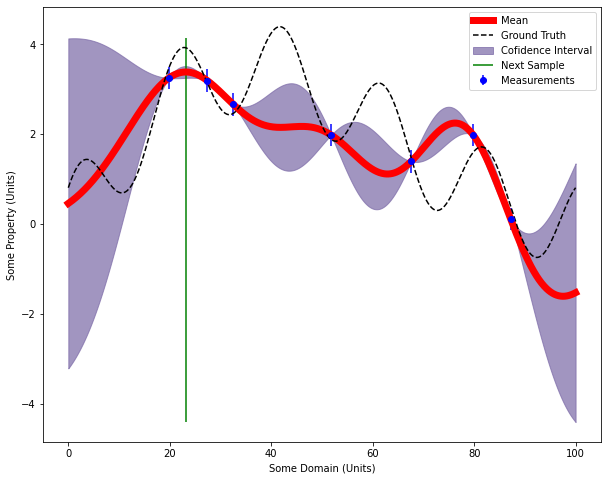

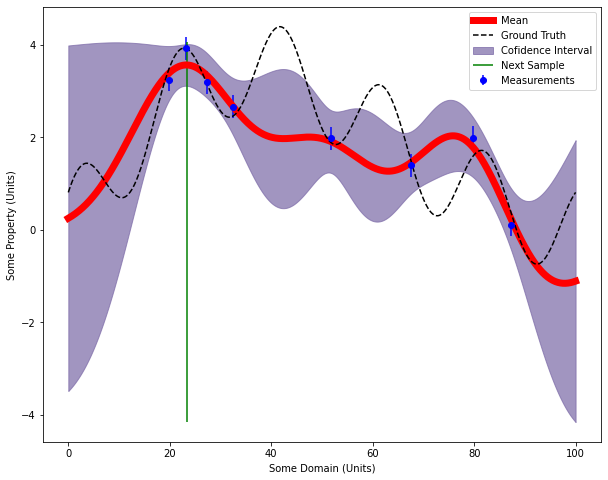

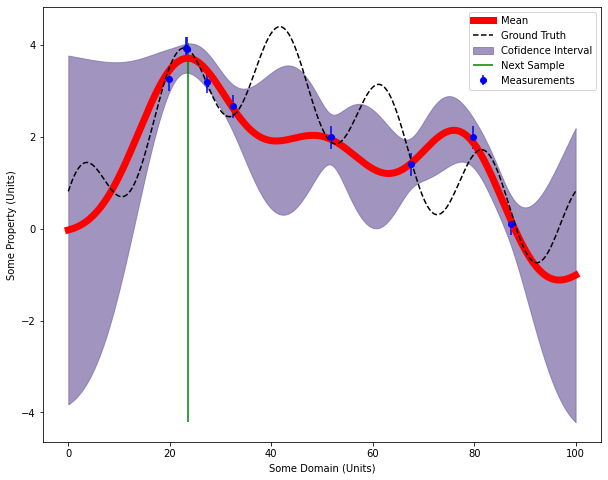

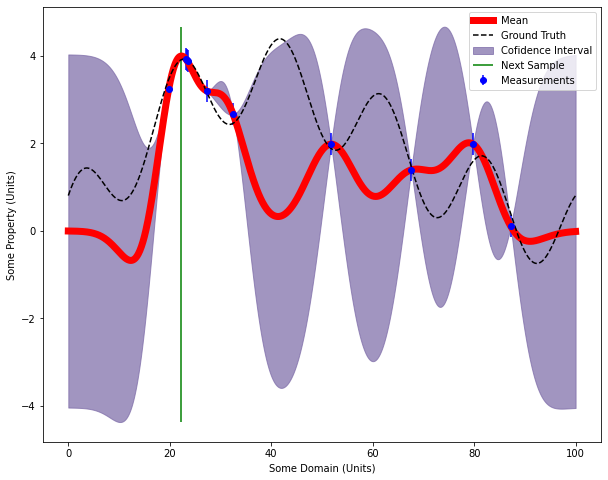

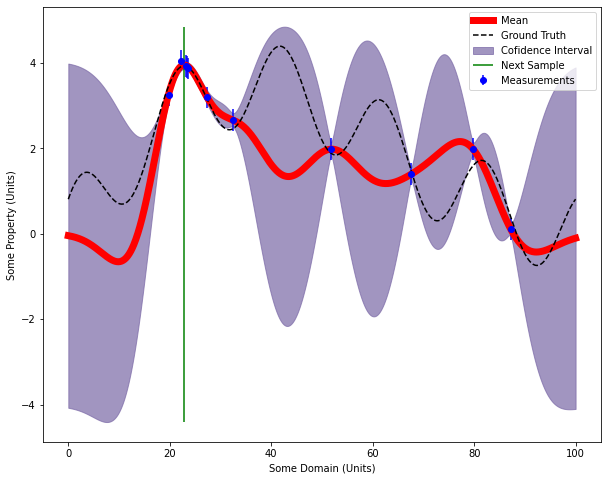

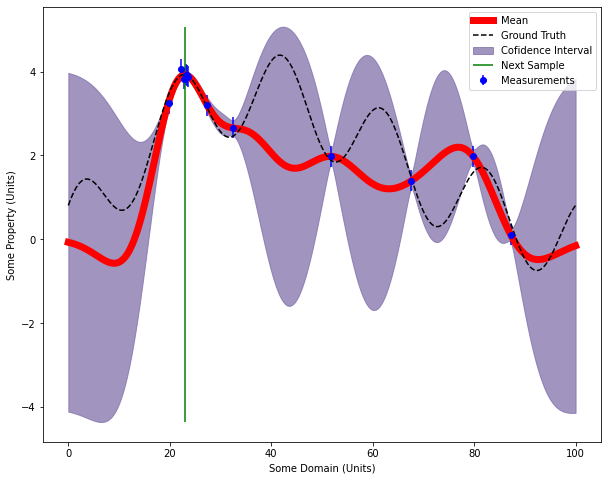

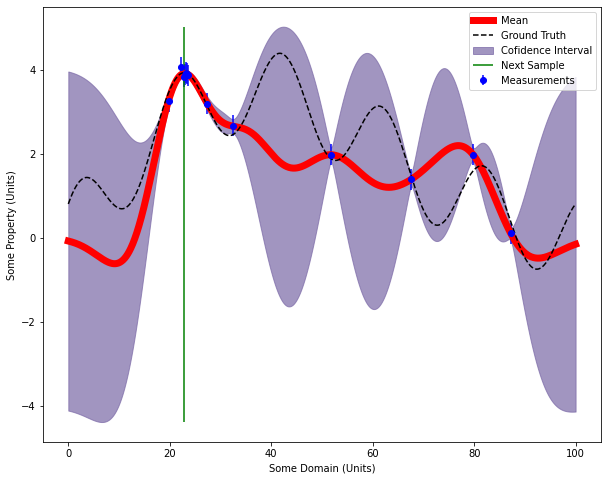

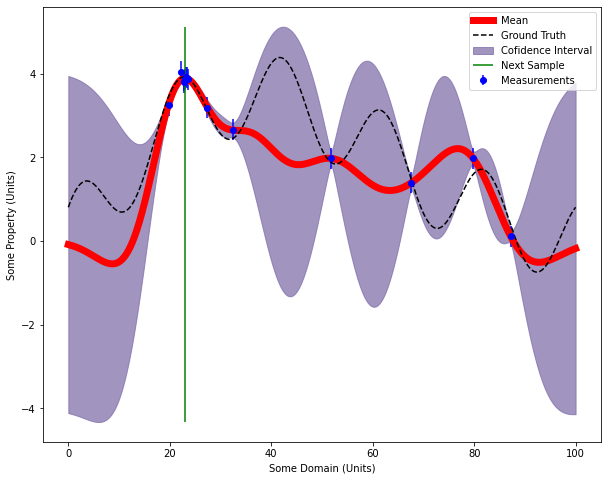

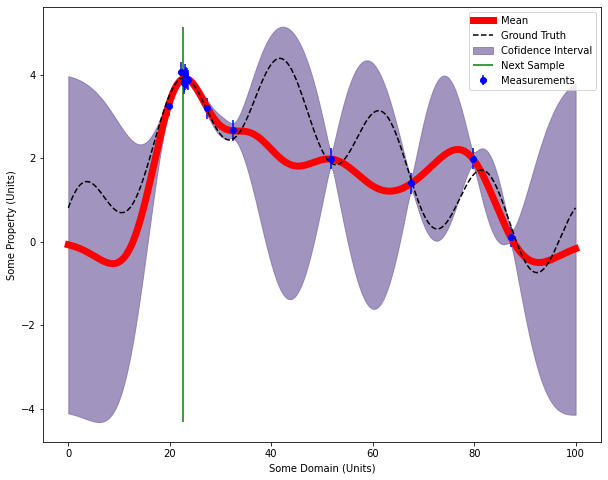

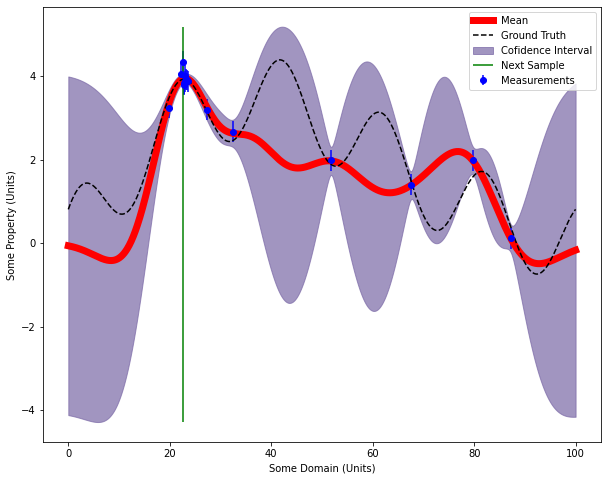

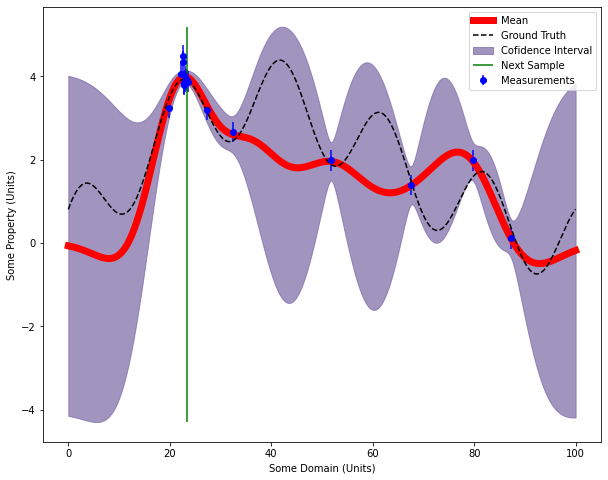

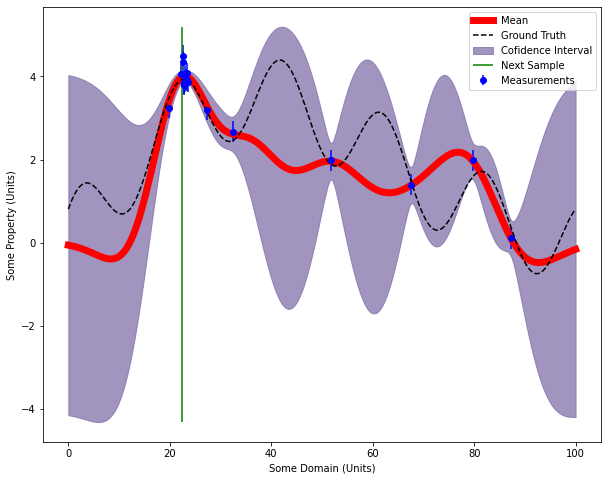

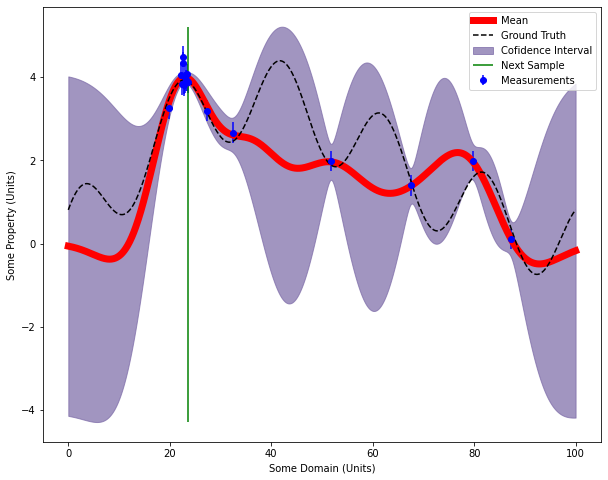

In [ ]:
#Initialize:
x_measured = x_starting
y_measured, y_measured_err = measure(x_measured)

#Active Learning Loops
for i in range(AL_loops):
  #Use a GP to analyze current data:
  model = Train_GPR(x_measured, y_measured)

  #Predict on ALL x locations:
  mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

  #Predict on unmeasured x locations:
  x_unmeasured = np.setdiff1d(x_test, x_measured)
  mean_unmeasured, var_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)))

  #Choose the next measurement:
  next = pure_exploit(mean_unmeasured, var_unmeasured)
  x_next = x_unmeasured[next]  
  
  #plot
  y_upperbound = tf.reshape(mean, -1) +1.96*np.sqrt(var[:,0])
  y_lowerbound = tf.reshape(mean, -1) -1.96*np.sqrt(var[:,0])
  plt.figure(figsize=(10,8))
  plt.plot(x_test, mean, "r-", linewidth=7.0, label = 'Mean')
  plt.fill_between(tf.reshape(x_test, -1), 
                   y_upperbound, 
                   y_lowerbound, 
                   alpha=0.7, color="#7A68A6", label = 'Cofidence Interval')
  plt.errorbar(x_measured, y_measured, y_measured_err, fmt = "bo", label = "Measurements")
  plt.plot(x_ground_truth,y_ground_truth, "k--", label = "Ground Truth")
  plt.vlines(x_next, ymin= np.min(y_lowerbound), ymax = np.max(y_upperbound), colors='g', label = 'Next Sample')
  plt.xlabel("Some Domain (Units)")
  plt.ylabel("Some Property (Units)")
  plt.legend()
  plt.plot()  
  plt.show()

  #Measure the new locations and add that to the training data
  y_next, y_next_err = measure(x_next)
  y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
  x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
  

# Upper Confedence Bound

In [ ]:
def upper_confedence_bound(mean, var):
  next = np.argmax(mean + 1.96*np.sqrt(var))
  return next

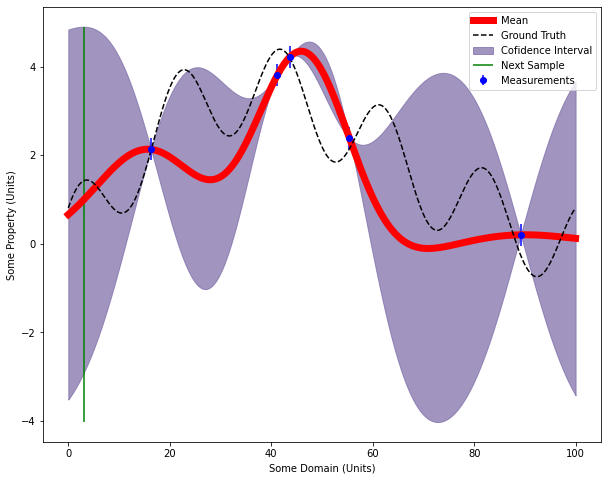

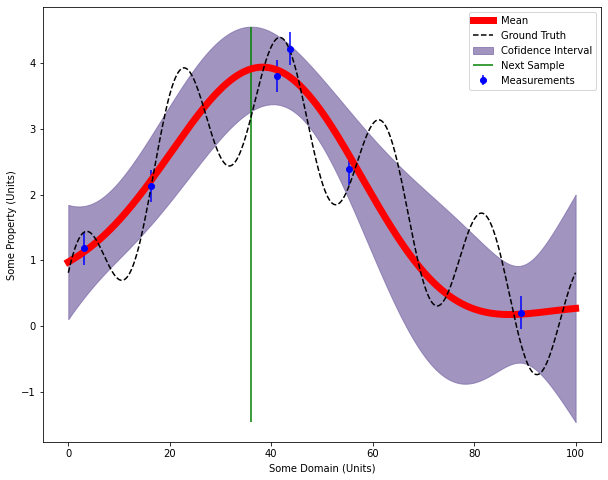

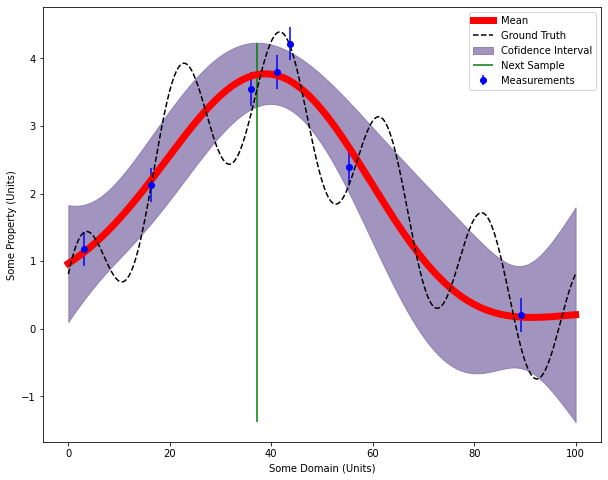

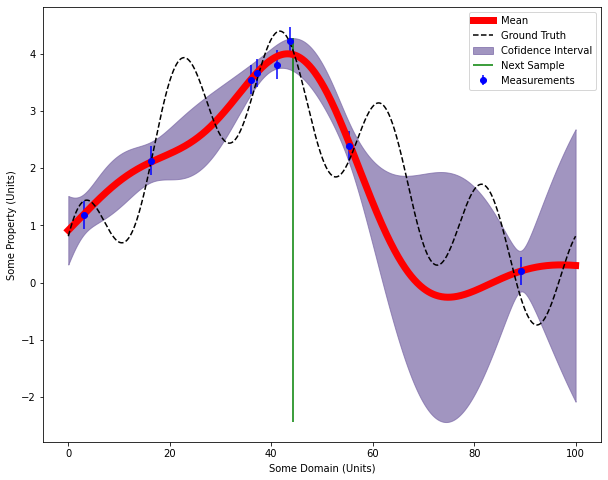

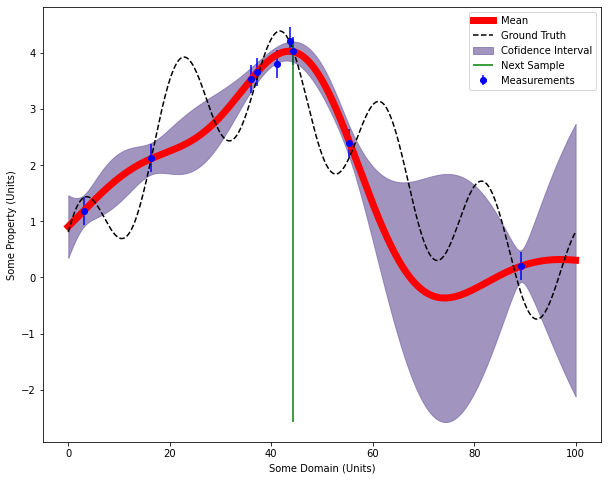

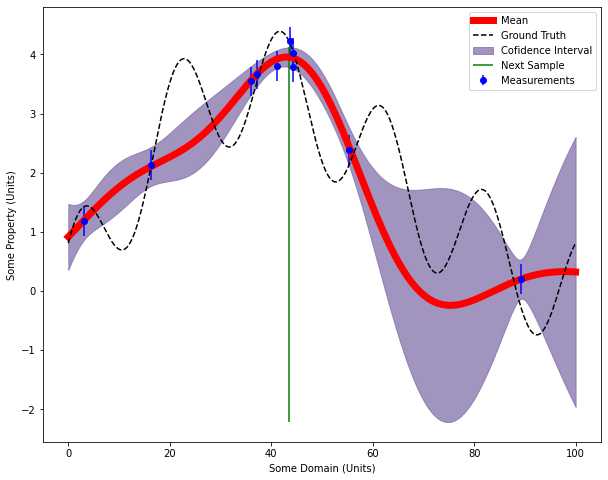

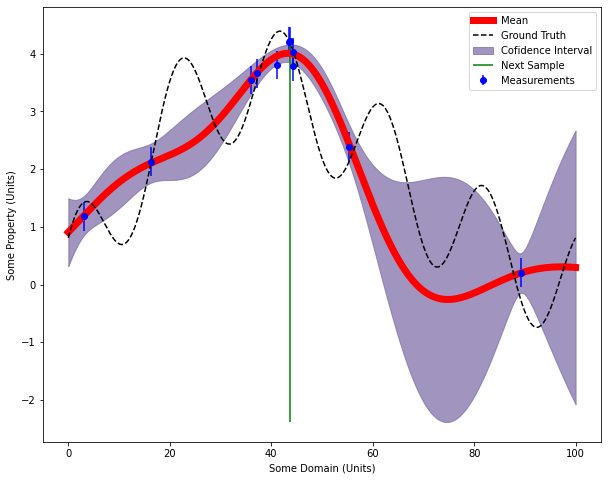

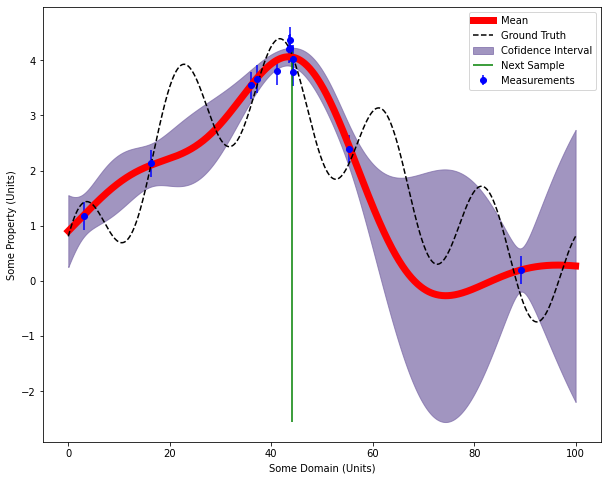

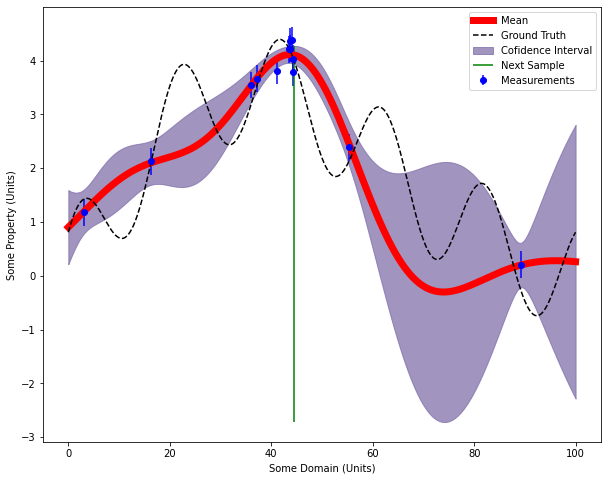

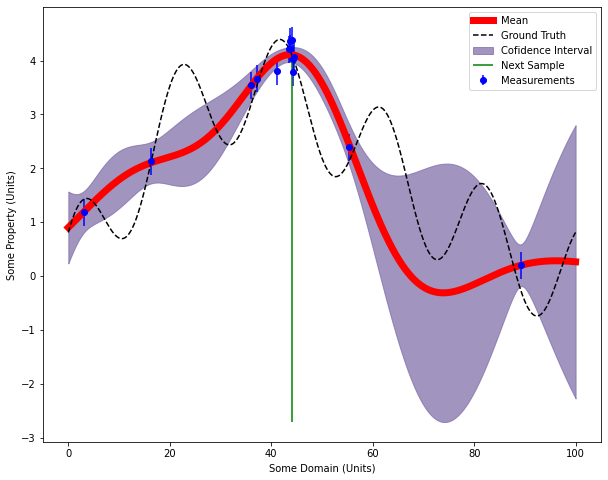

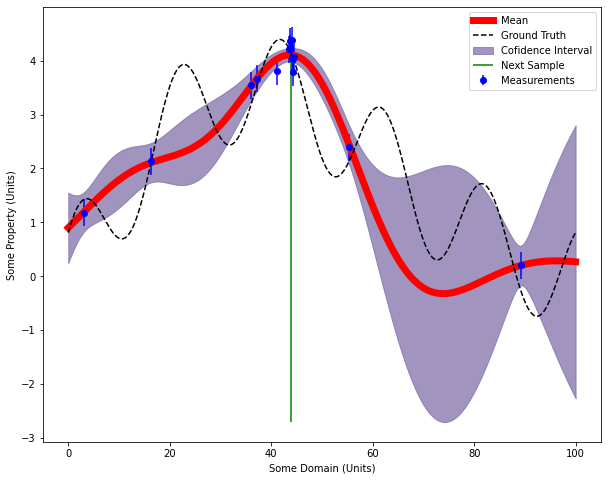

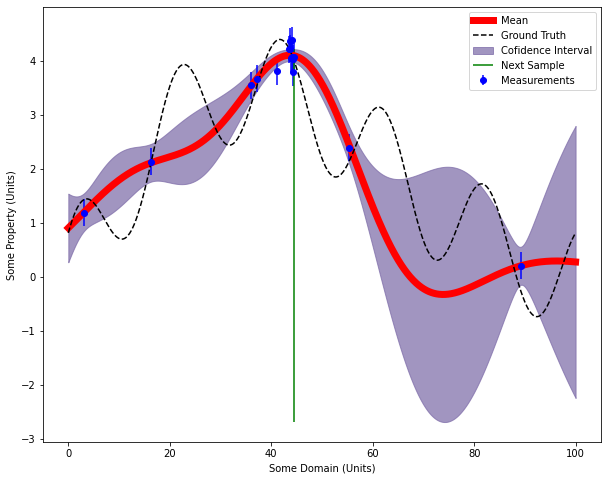

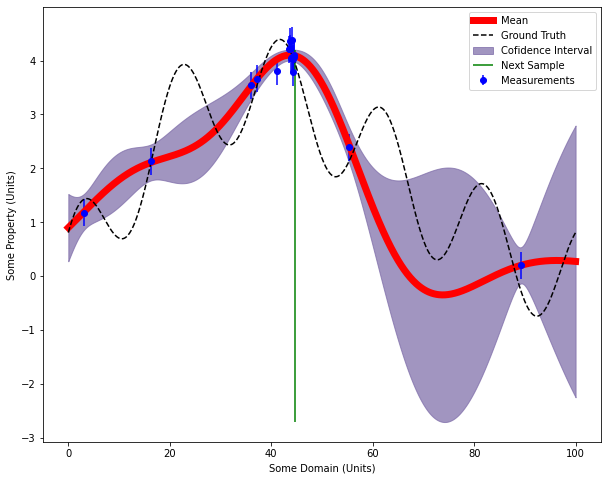

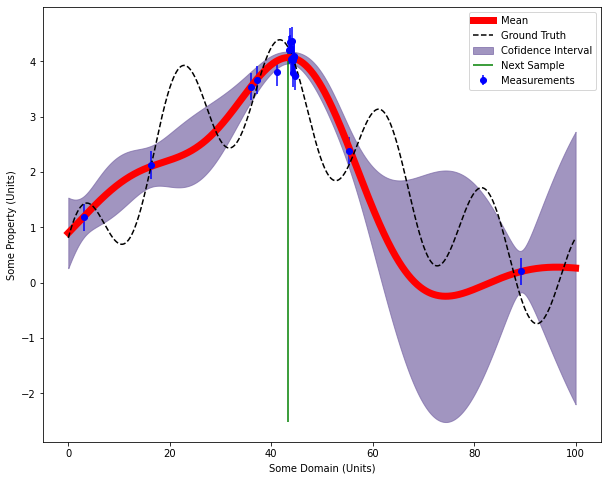

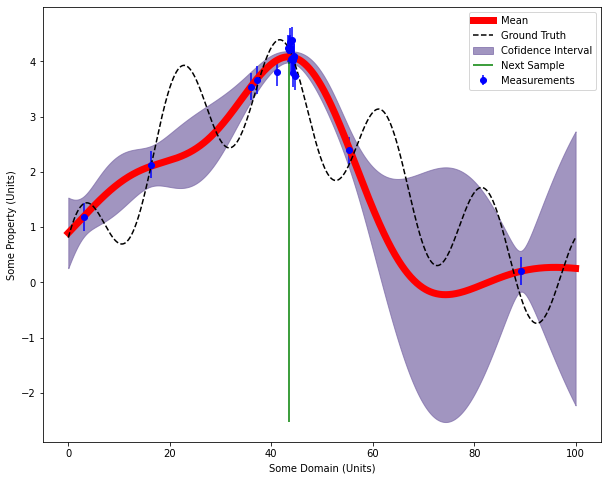

In [ ]:
#Initialize:
starting_measurements = 5
x_measured = np.random.permutation(x_test)[:starting_measurements]
y_measured, y_measured_err = measure(x_measured)

#Active Learning Loops
for i in range(AL_loops):
  #Use a GP to analyze current data:
  model = Train_GPR(x_measured, y_measured)

  #Predict on ALL x locations:
  mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

  #Predict on unmeasured x locations:
  x_unmeasured = np.setdiff1d(x_test, x_measured)
  mean_unmeasured, var_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)))

  #Choose the next measurement:
  next = upper_confedence_bound(mean_unmeasured, var_unmeasured)
  x_next = x_unmeasured[next]  
  
  #plot
  y_upperbound = tf.reshape(mean, -1) +1.96*np.sqrt(var[:,0])
  y_lowerbound = tf.reshape(mean, -1) -1.96*np.sqrt(var[:,0])
  plt.figure(figsize=(10,8))
  plt.plot(x_test, mean, "r-", linewidth=7.0, label = 'Mean')
  plt.fill_between(tf.reshape(x_test, -1), 
                   y_upperbound, 
                   y_lowerbound, 
                   alpha=0.7, color="#7A68A6", label = 'Cofidence Interval')
  plt.errorbar(x_measured, y_measured, y_measured_err, fmt = "bo", label = "Measurements")
  plt.plot(x_ground_truth,y_ground_truth, "k--", label = "Ground Truth")
  plt.vlines(x_next, ymin= np.min(y_lowerbound), ymax = np.max(y_upperbound), colors='g', label = 'Next Sample')
  plt.xlabel("Some Domain (Units)")
  plt.ylabel("Some Property (Units)")
  plt.legend()
  plt.plot()  
  plt.show()

  #Measure the new locations and add that to the training data
  y_next, y_next_err = measure(x_next)
  y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
  x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
  

## Scheduled Upper Confidence

In [ ]:
def scheduled_upper_confedence(mean, var, n_measured):
  beta = 1.96*n_measured/2
  next = np.argmax(mean + beta*np.sqrt(var))
  return next

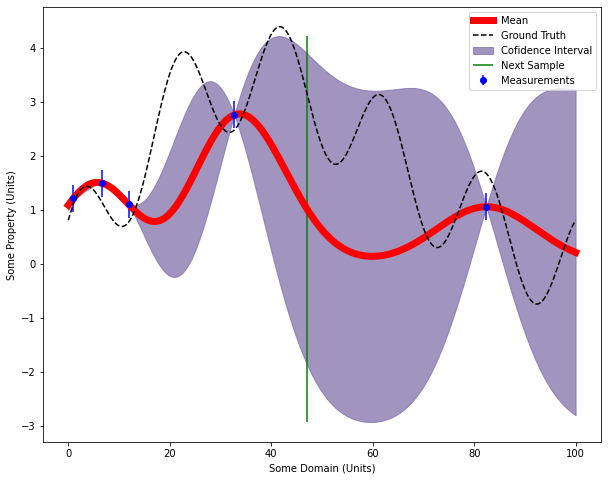

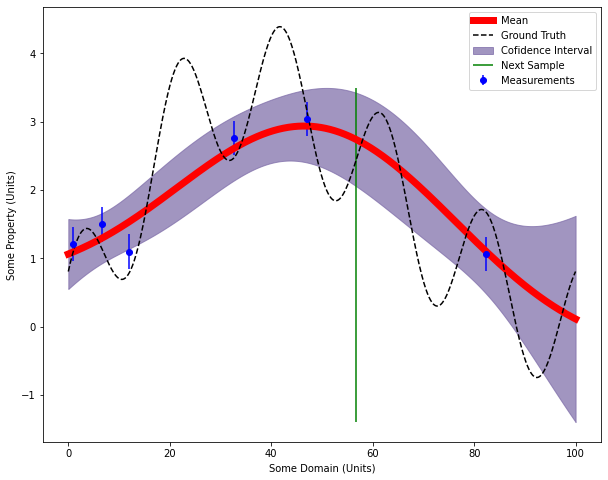

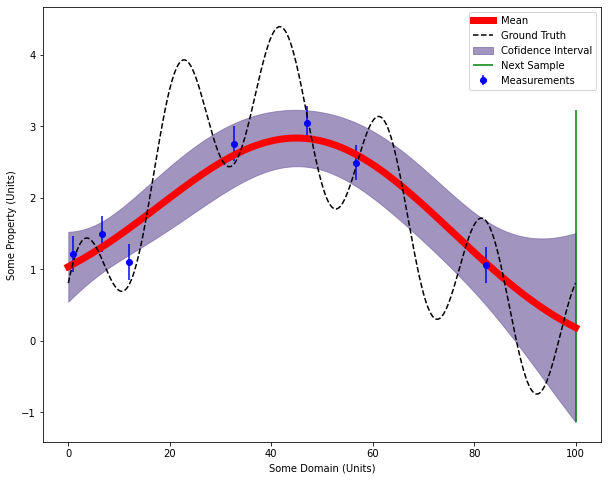

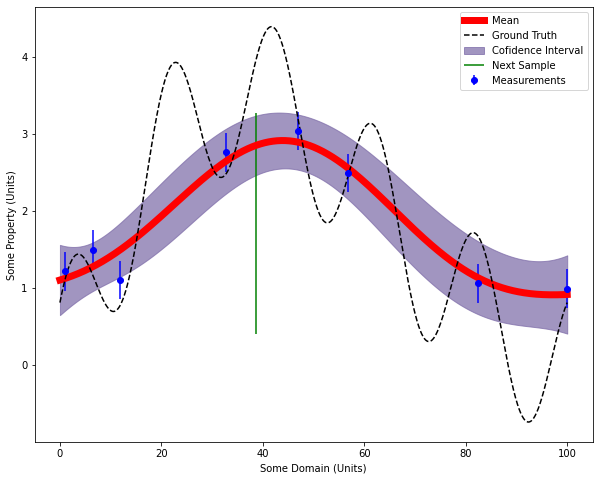

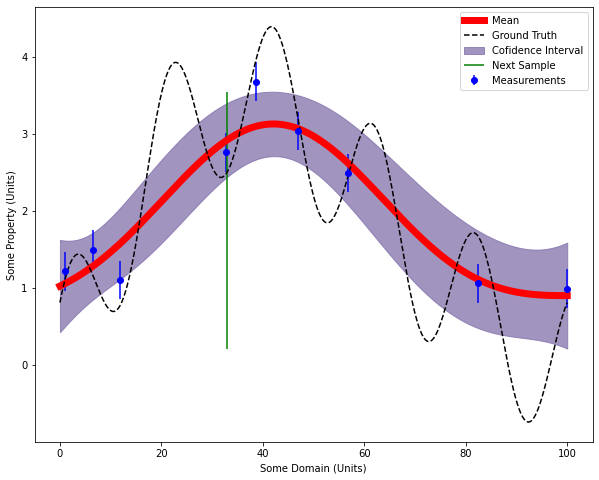

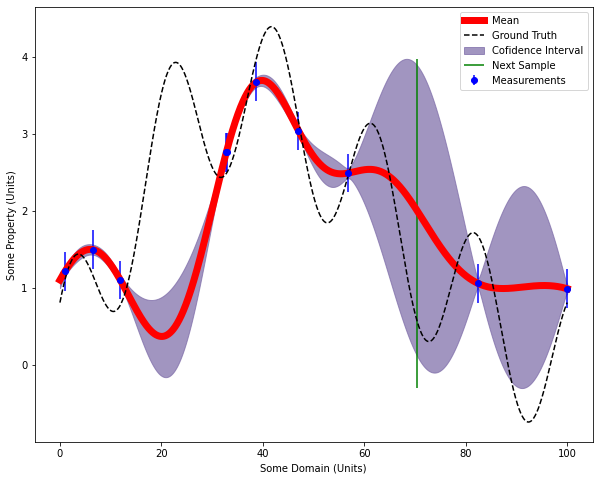

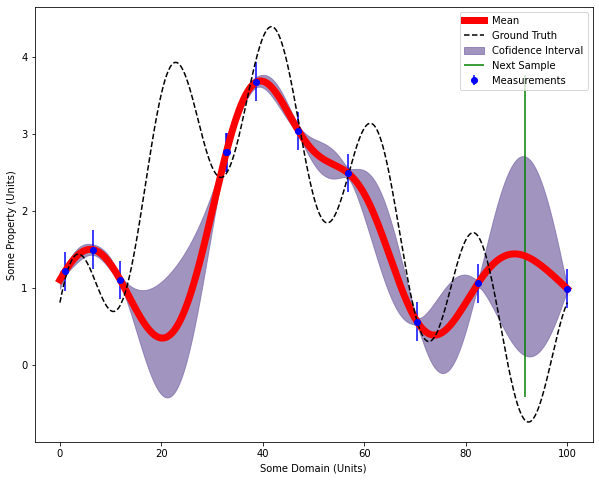

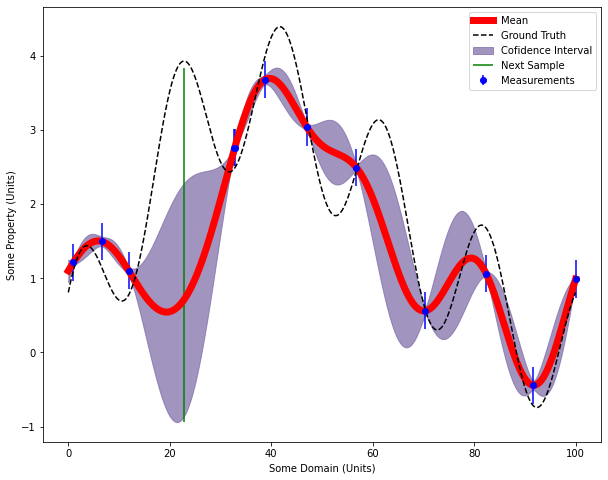

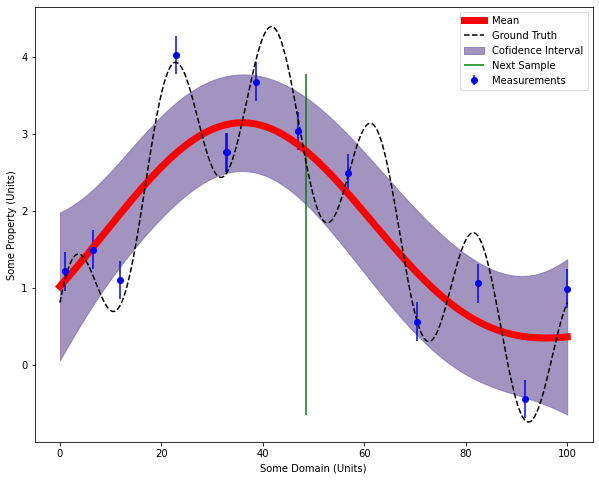

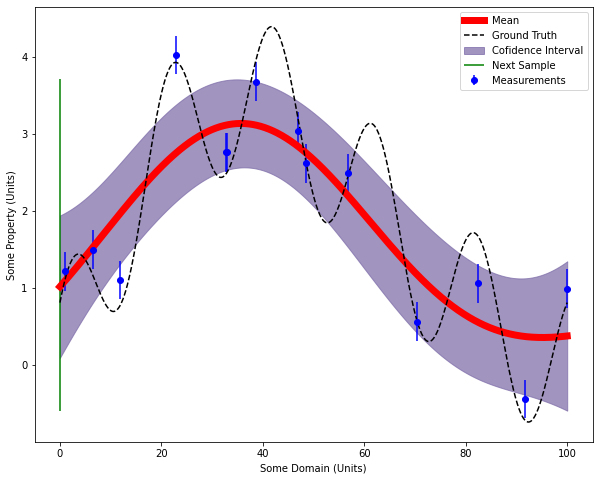

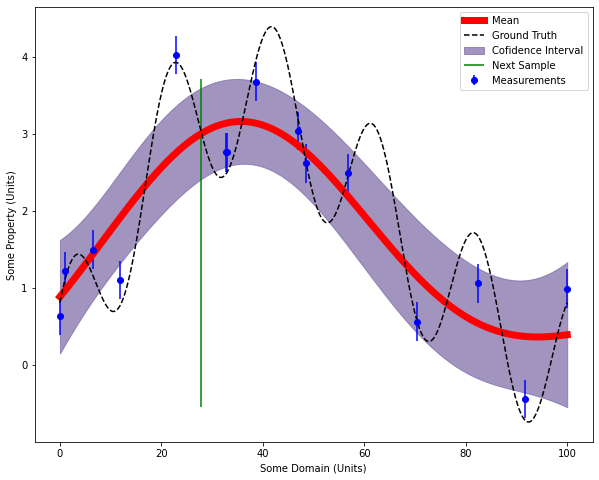

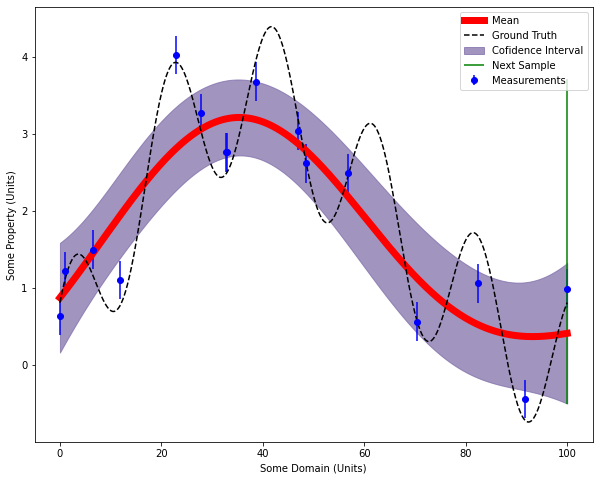

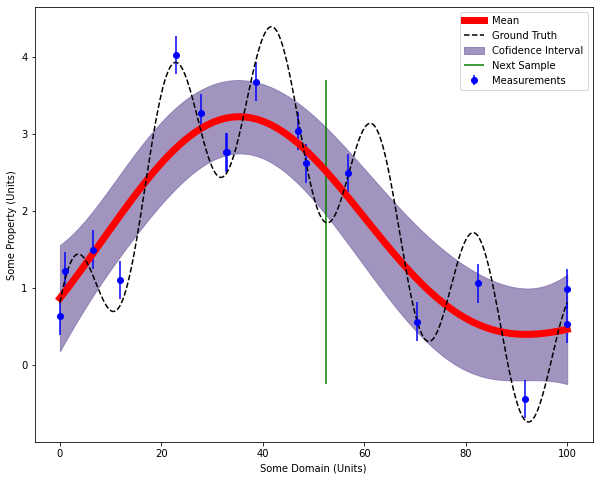

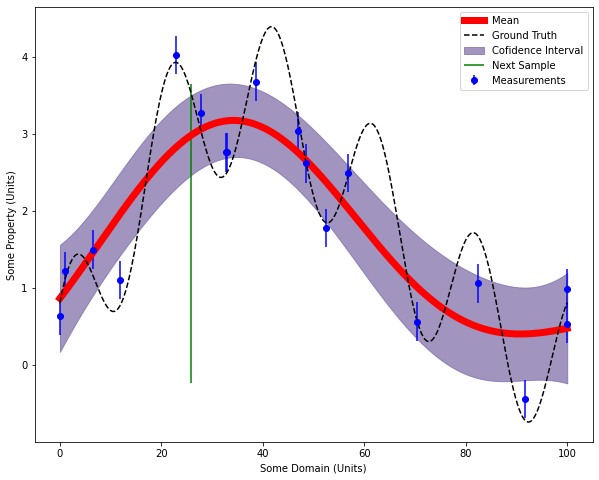

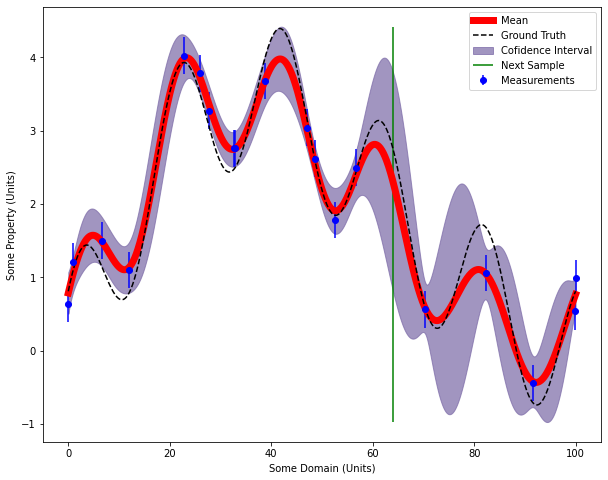

In [ ]:
#Initialize:
starting_measurements = 5
x_measured = np.random.permutation(x_test)[:starting_measurements]
y_measured, y_measured_err = measure(x_measured)

#Active Learning Loops
for i in range(AL_loops):
  #Use a GP to analyze current data:
  model = Train_GPR(x_measured, y_measured)

  #Predict on ALL x locations:
  mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

  #Predict on unmeasured x locations:
  x_unmeasured = np.setdiff1d(x_test, x_measured)
  mean_unmeasured, var_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)))

  #Choose the next measurement:
  next = scheduled_upper_confedence(mean_unmeasured, var_unmeasured, len(x_measured))
  x_next = x_unmeasured[next]  
  
  #plot
  y_upperbound = tf.reshape(mean, -1) +1.96*np.sqrt(var[:,0])
  y_lowerbound = tf.reshape(mean, -1) -1.96*np.sqrt(var[:,0])
  plt.figure(figsize=(10,8))
  plt.plot(x_test, mean, "r-", linewidth=7.0, label = 'Mean')
  plt.fill_between(tf.reshape(x_test, -1), 
                   y_upperbound, 
                   y_lowerbound, 
                   alpha=0.7, color="#7A68A6", label = 'Cofidence Interval')
  plt.errorbar(x_measured, y_measured, y_measured_err, fmt = "bo", label = "Measurements")
  plt.plot(x_ground_truth,y_ground_truth, "k--", label = "Ground Truth")
  plt.vlines(x_next, ymin= np.min(y_lowerbound), ymax = np.max(y_upperbound), colors='g', label = 'Next Sample')
  plt.xlabel("Some Domain (Units)")
  plt.ylabel("Some Property (Units)")
  plt.legend()
  plt.plot()  
  plt.show()

  #Measure the new locations and add that to the training data
  y_next, y_next_err = measure(x_next)
  y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
  x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
  

# Thompson Sampling

In [ ]:
def thompson_sample(mean, cov, samples, x_predict):
  cov = cov[0,:,:]
  #Define a multivariate normal distribution and take draws from that
  Y = np.random.multivariate_normal(np.array(mean).flatten(),
                                  np.array(cov),
                                  size = samples)
  
  #Find the max point in each draw
  next_points = []
  for y in Y:
    next = np.argmax(y)
    next_points.append(next)
  
  next_args = np.array(next_points)
  
  #Return the list of indexs and the draws
  return next_args, Y


  



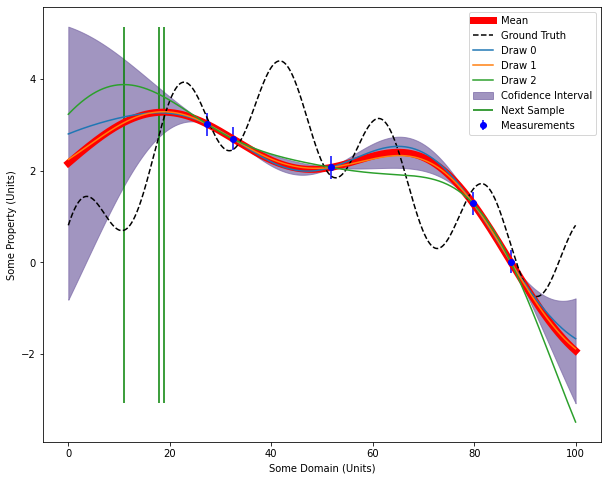

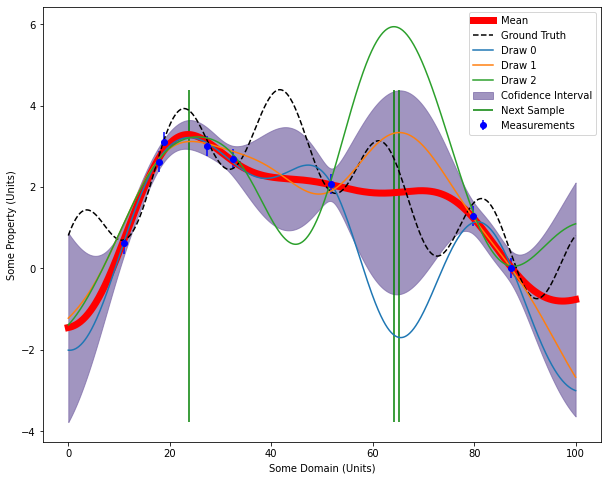

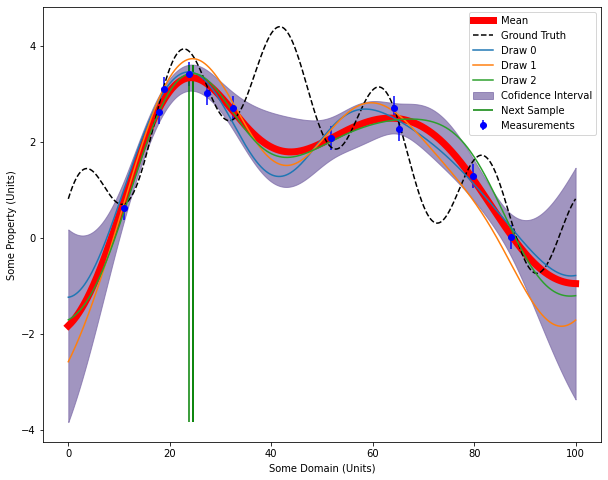

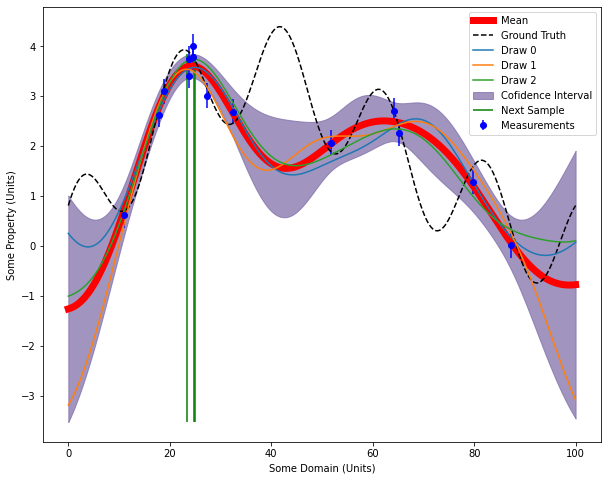

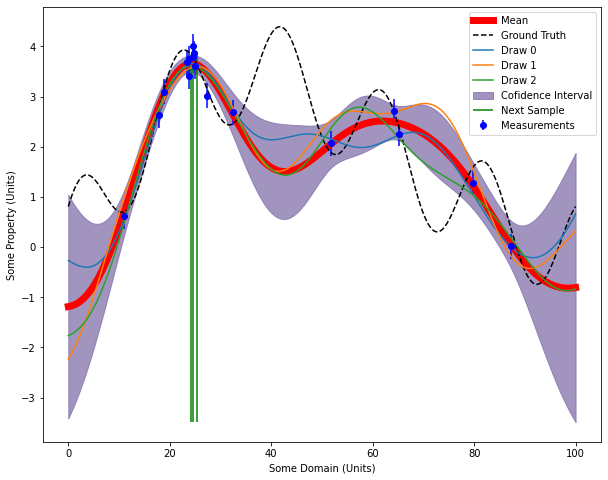

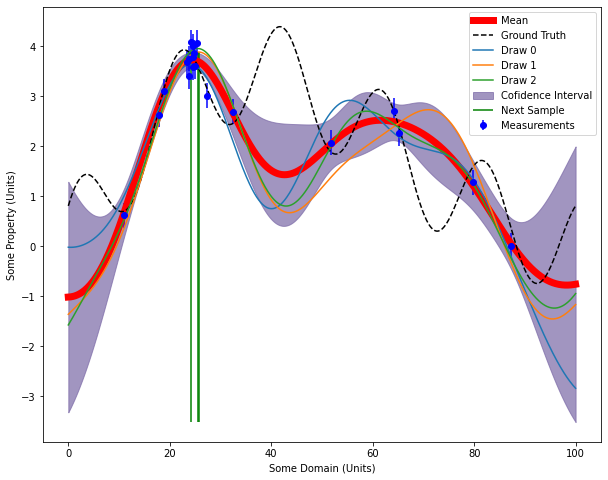

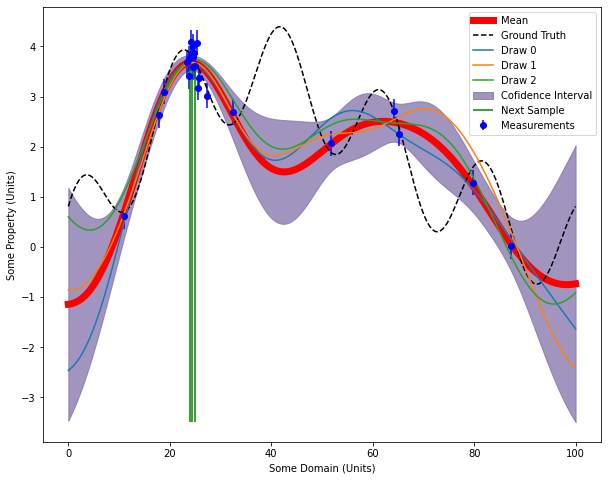

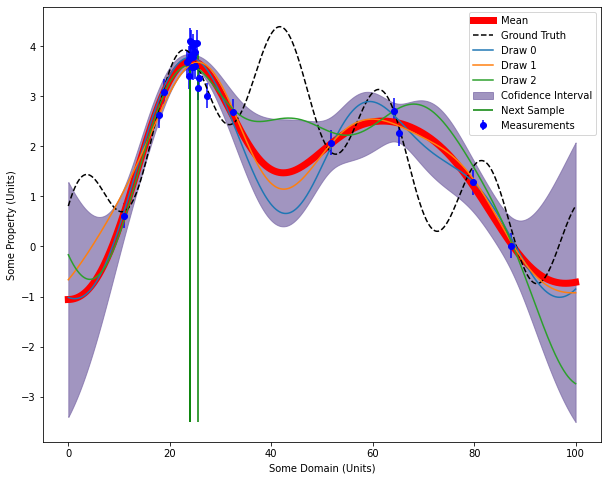

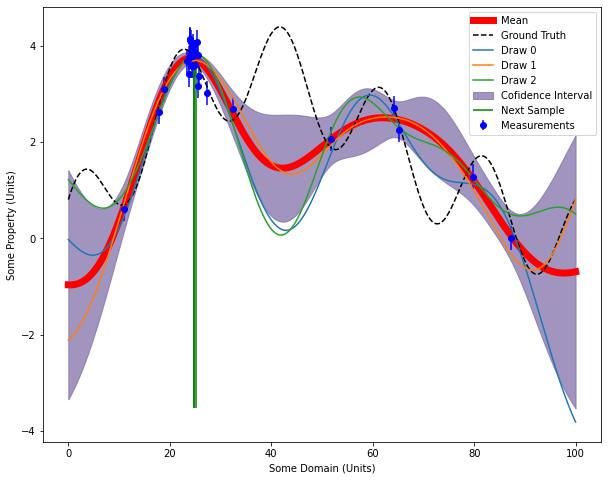

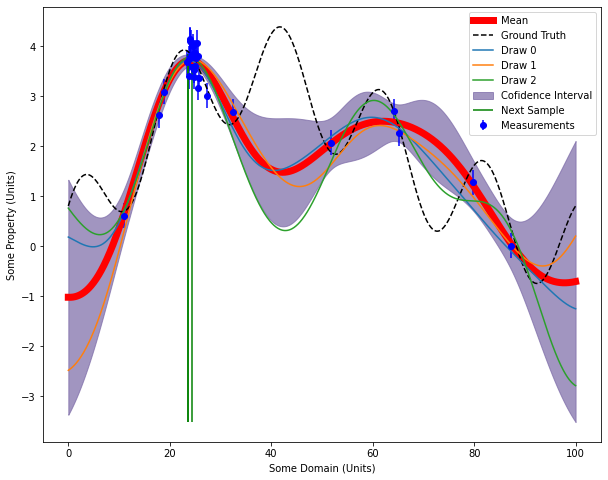

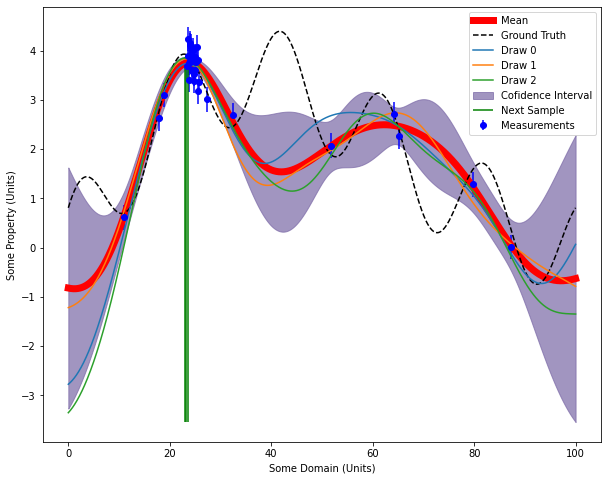

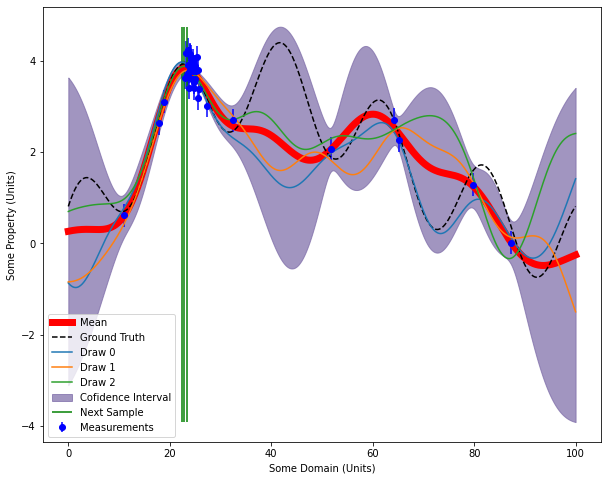

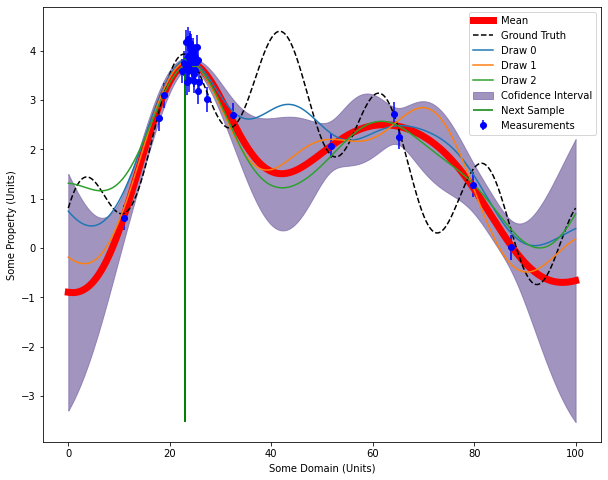

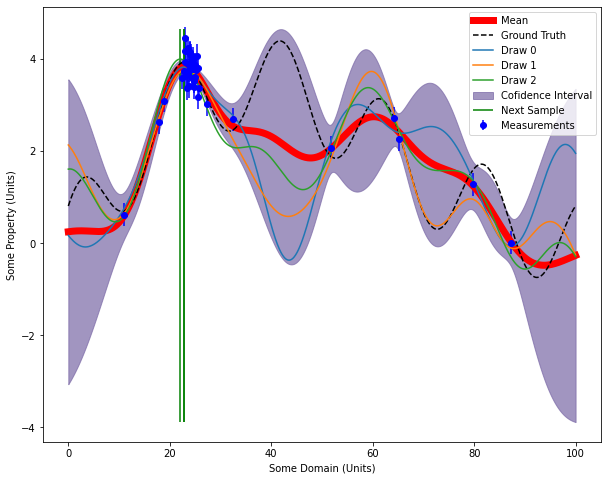

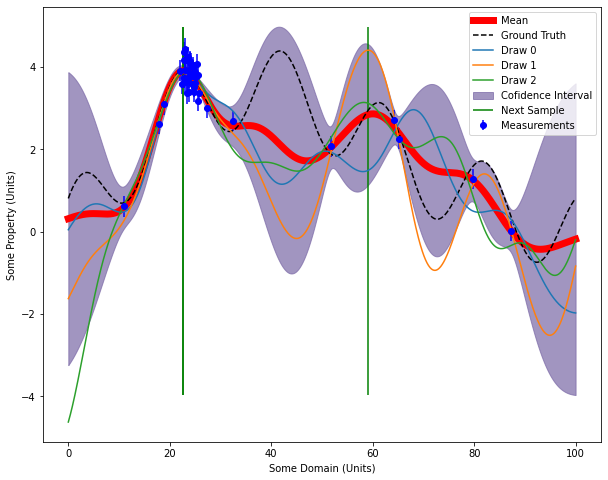

In [ ]:
#Initialize:
x_measured = x_starting
y_measured, y_measured_err = measure(x_measured)

#Active Learning Loops
for i in range(AL_loops):
  #Use a GP to analyze current data:
  model = Train_GPR(x_measured, y_measured)

  #Predict on ALL x locations:
  mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

  #Predict on unmeasured x locations:
  x_unmeasured = np.setdiff1d(x_test, x_measured)
  mean_unmeasured, cov_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)), 
                                                    full_cov=True)

  #Choose the next measurement:
  next, Y = thompson_sample(mean_unmeasured, cov_unmeasured, 3, x_unmeasured)
  x_next = x_unmeasured[next]  
  
  #plot
  y_upperbound = tf.reshape(mean, -1) +1.96*np.sqrt(var[:,0])
  y_lowerbound = tf.reshape(mean, -1) -1.96*np.sqrt(var[:,0])
  plt.figure(figsize=(10,8))
  plt.plot(x_test, mean, "r-", linewidth=7.0, label = 'Mean')
  plt.fill_between(tf.reshape(x_test, -1), 
                   y_upperbound, 
                   y_lowerbound, 
                   alpha=0.7, color="#7A68A6", label = 'Cofidence Interval')
  plt.errorbar(x_measured, y_measured, y_measured_err, fmt = "bo", label = "Measurements")
  plt.plot(x_ground_truth,y_ground_truth, "k--", label = "Ground Truth")
  plt.vlines(x_next, ymin= np.min(y_lowerbound), ymax = np.max(y_upperbound), colors='g', label = 'Next Sample')
  for j in range(Y.shape[0]):
    plt.plot(np.array(x_unmeasured),
           Y[j,:], label = f'Draw {j}')
  plt.xlabel("Some Domain (Units)")
  plt.ylabel("Some Property (Units)")
  plt.legend()
  plt.plot()  
  plt.show()

  #Measure the new locations and add that to the training data
  y_next, y_next_err = measure(x_next)
  y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
  x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
  

# Probability of Improvement
Recall that at every location in the Domain (x-axis) the Gaussian Process is a Gaussian Distribution. We can therefore calculate the probability of finding a measurement above our current optimum and choose the point that has the highest probability of finding an improvement. 

In [ ]:
from scipy.special import erf

In [ ]:
def probability_of_improvement(mean, var, y_measured):
  y_best = np.max(y_measured)
  #Calculate the probability of finding a measurment above the current best
  PoI = 1 - 0.5*(1 + erf((y_best - mean)/(np.sqrt(var * 2))))


  #Choose the highest probability
  next = np.argmax(PoI)
  return next


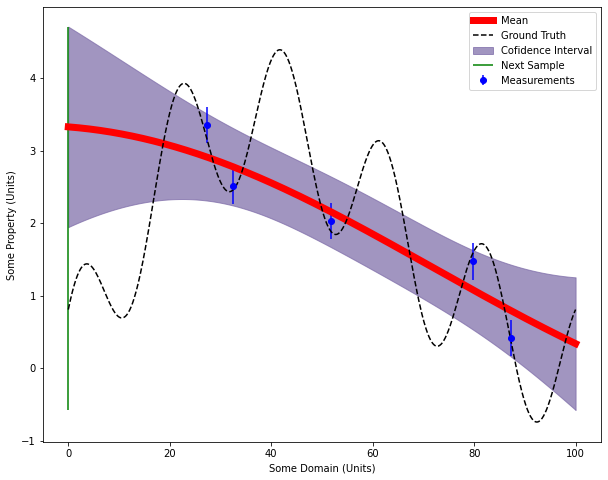

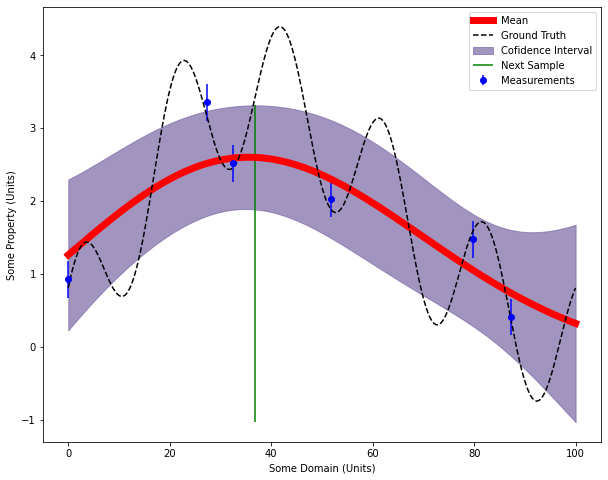

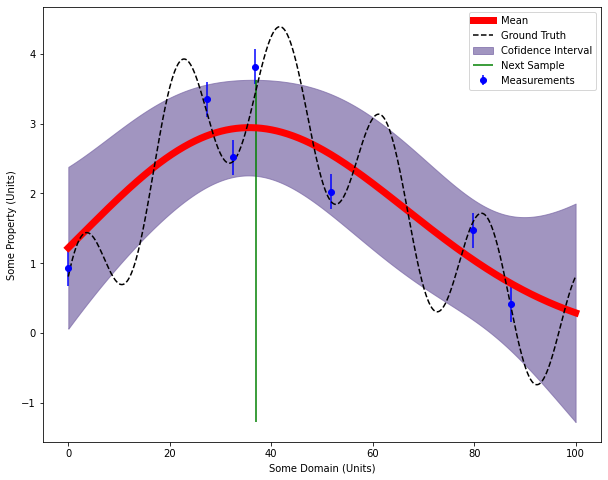

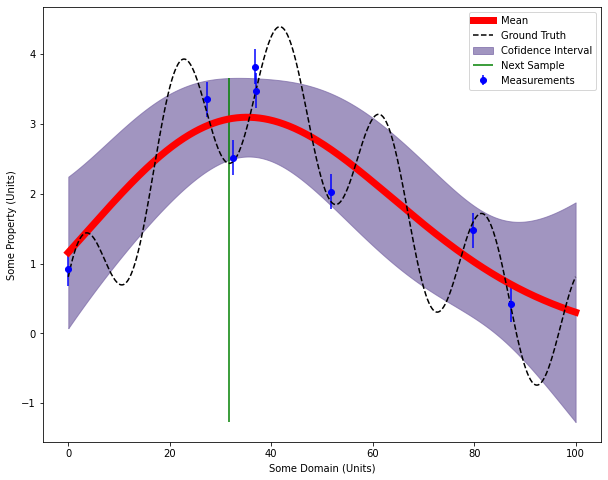

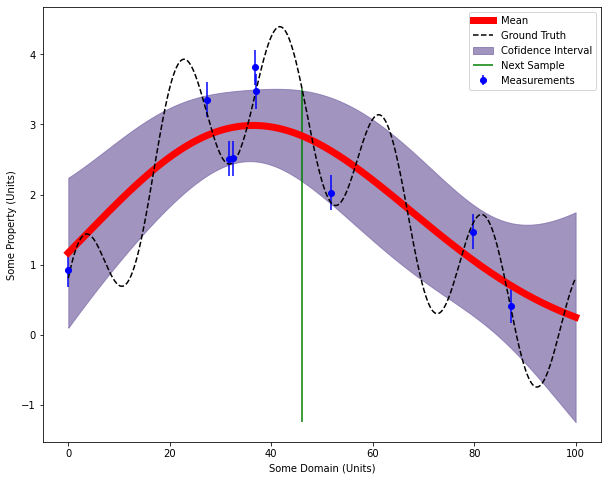

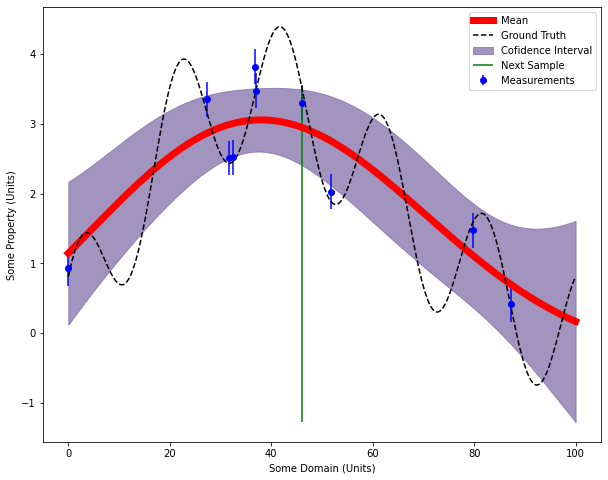

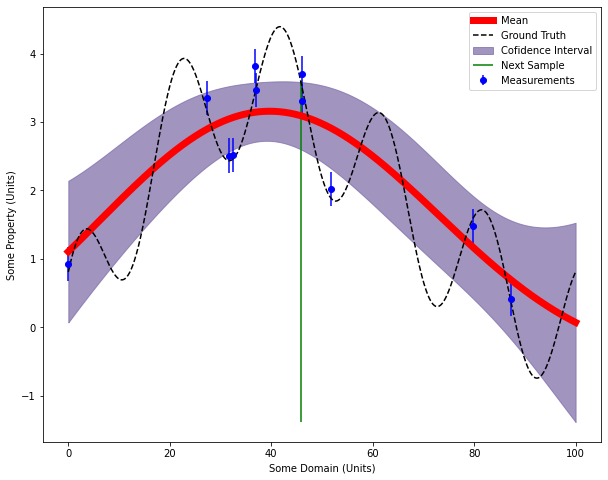

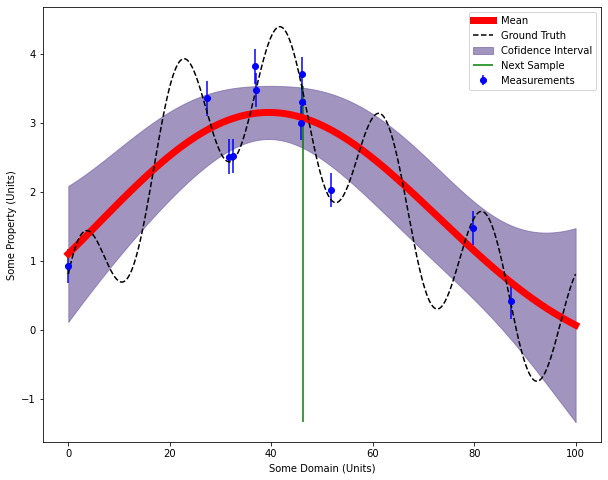

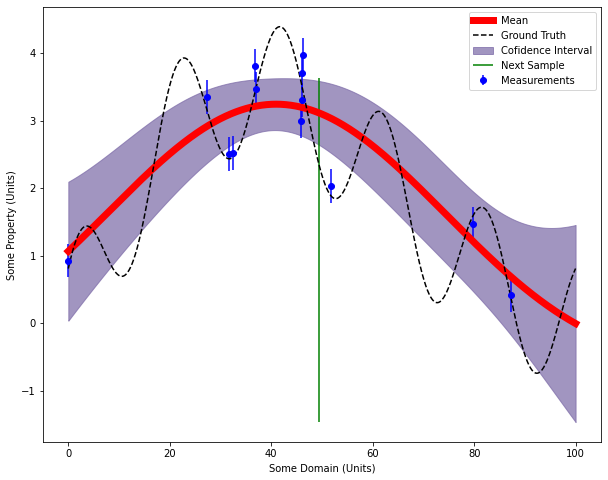

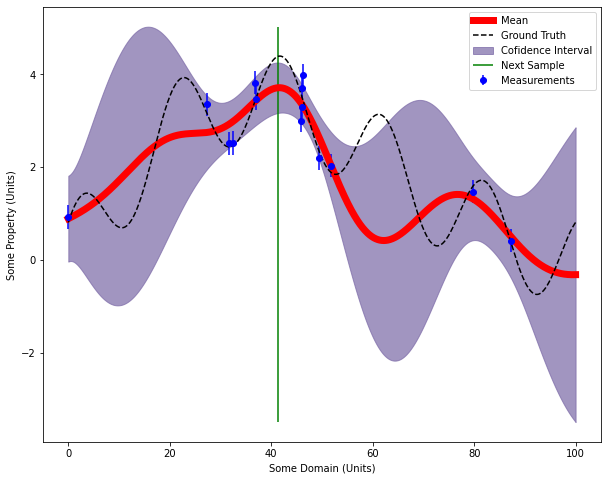

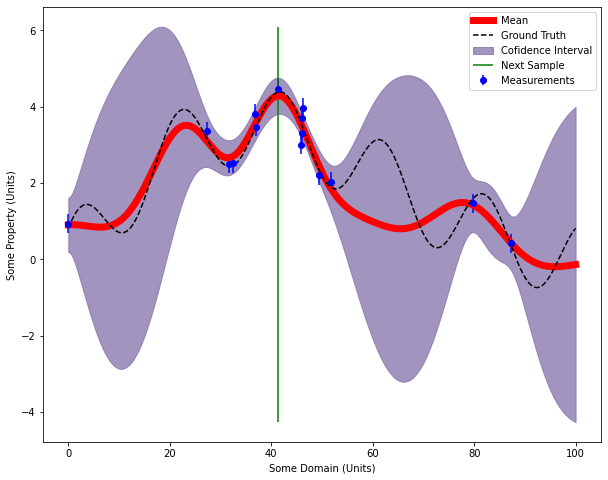

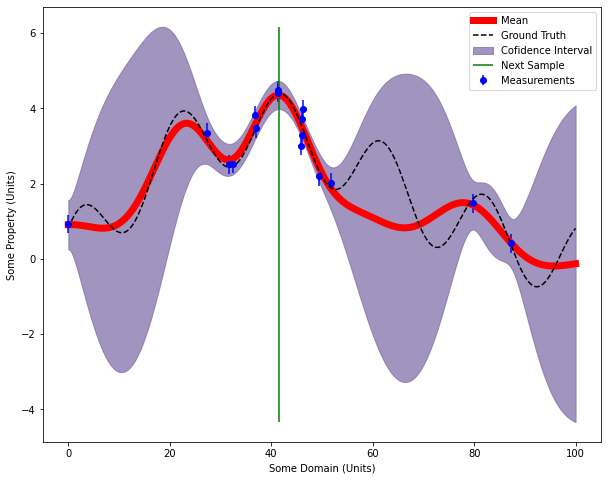

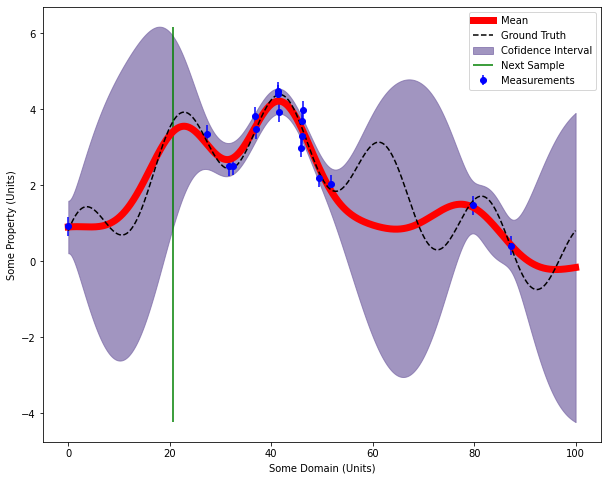

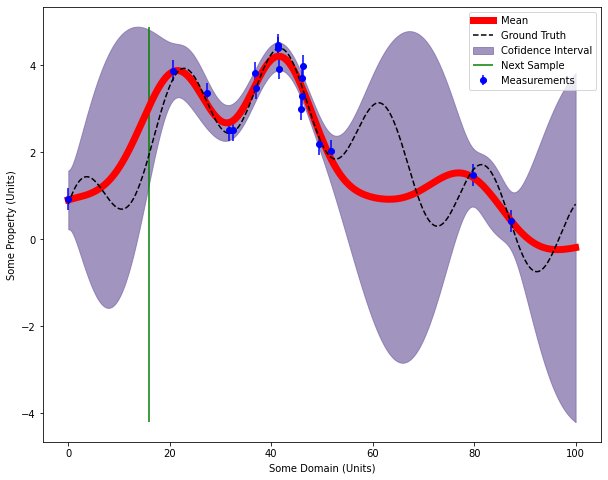

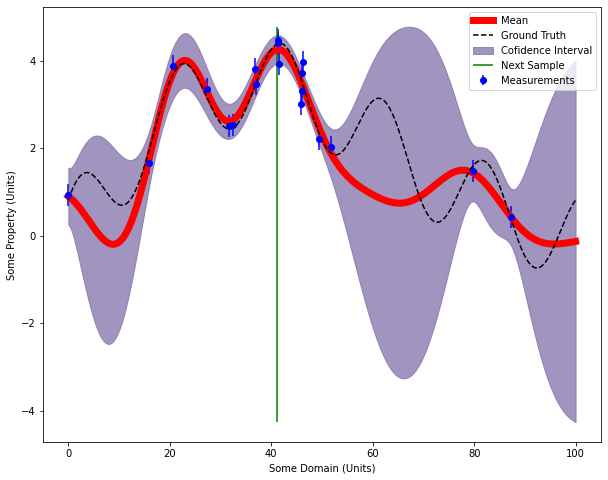

In [ ]:
#Initialize:
x_measured = x_starting
y_measured, y_measured_err = measure(x_measured)

#Active Learning Loops
for i in range(AL_loops):
  #Use a GP to analyze current data:
  model = Train_GPR(x_measured, y_measured)

  #Predict on ALL x locations:
  mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

  #Predict on unmeasured x locations:
  x_unmeasured = np.setdiff1d(x_test, x_measured)
  mean_unmeasured, var_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)))

  #Choose the next measurement:
  next= probability_of_improvement(mean_unmeasured, var_unmeasured, y_measured)
  x_next = x_unmeasured[next]  
  
  #plot
  y_upperbound = tf.reshape(mean, -1) +1.96*np.sqrt(var[:,0])
  y_lowerbound = tf.reshape(mean, -1) -1.96*np.sqrt(var[:,0])
  plt.figure(figsize=(10,8))
  plt.plot(x_test, mean, "r-", linewidth=7.0, label = 'Mean')
  plt.fill_between(tf.reshape(x_test, -1), 
                   y_upperbound, 
                   y_lowerbound, 
                   alpha=0.7, color="#7A68A6", label = 'Cofidence Interval')
  plt.errorbar(x_measured, y_measured, y_measured_err, fmt = "bo", label = "Measurements")
  plt.plot(x_ground_truth,y_ground_truth, "k--", label = "Ground Truth")
  plt.vlines(x_next, ymin= np.min(y_lowerbound), ymax = np.max(y_upperbound), colors='g', label = 'Next Sample')
  plt.xlabel("Some Domain (Units)")
  plt.ylabel("Some Property (Units)")
  plt.legend()
  plt.plot()  
  plt.show()

  #Measure the new locations and add that to the training data
  y_next, y_next_err = measure(x_next)
  y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
  x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
  

# Expected Improvement

The probablility of improvement didn't account for how big the improvement would be, only probability that the measured value would be larger than the current value - no matter how incrimental the improvement might be. To account for the size of the improvement, we can use the expected improvement.

In [ ]:
def expected_improvement(mean, var, y_measured):
  y_best = np.max(y_measured)
  
  # alpha = (y_best - mean)/np.sqrt(var)
  alpha = (mean - y_best)/np.sqrt(var)

  phi_alpha = np.exp(-0.5*(alpha - 0)**2/1)/(np.sqrt(1*2*np.pi))
  Phi_alpha = 0.5*(1 + erf((alpha - 0)/(np.sqrt(1 * 2))))

  #Calculate the expected improvement
  EI = (mean - y_best)*(Phi_alpha) + np.sqrt(var)*phi_alpha
  
  #Choose the highest expected improvement
  next = np.argmax(EI)
  return next


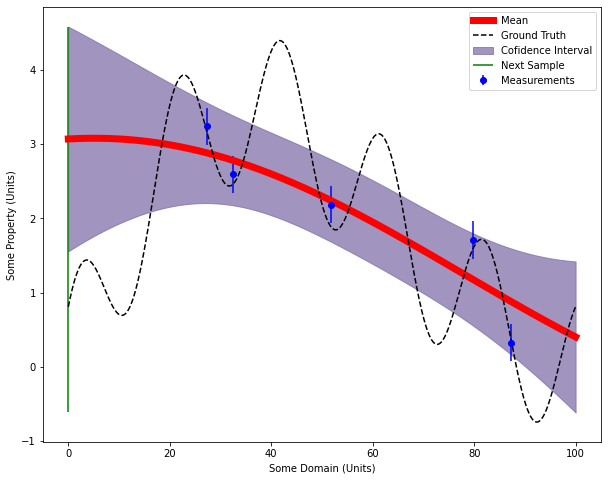

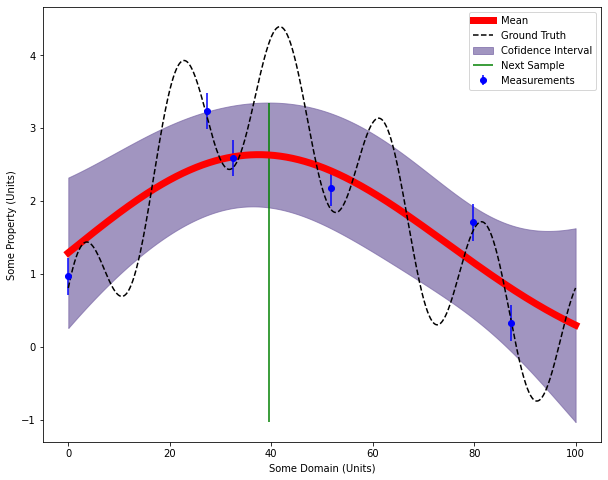

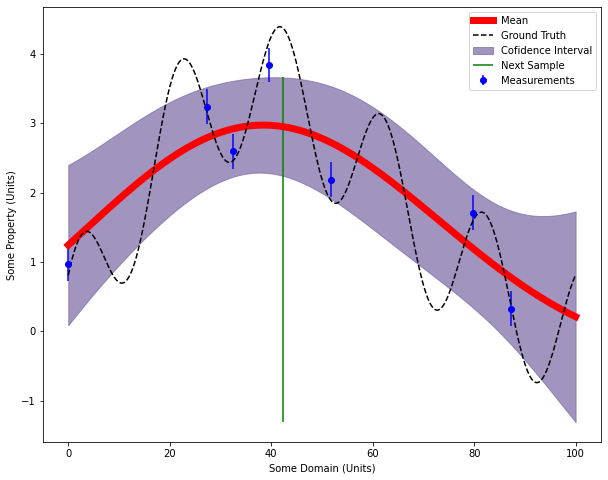

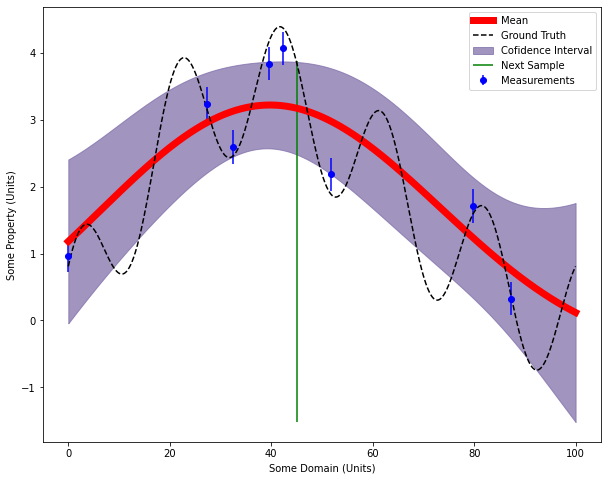

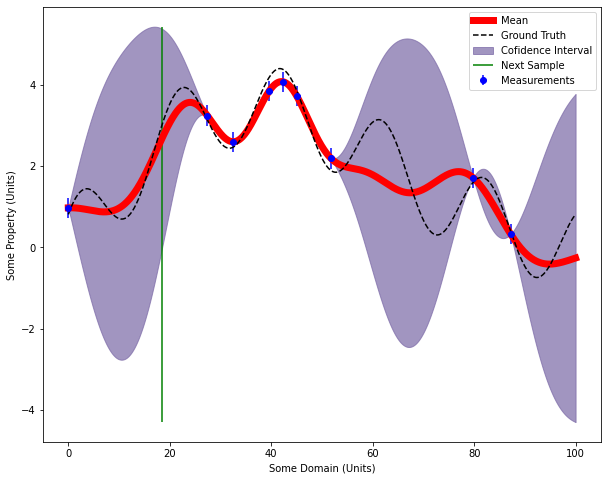

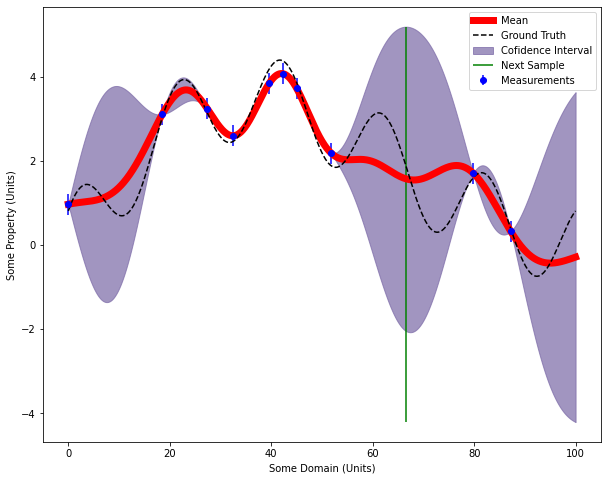

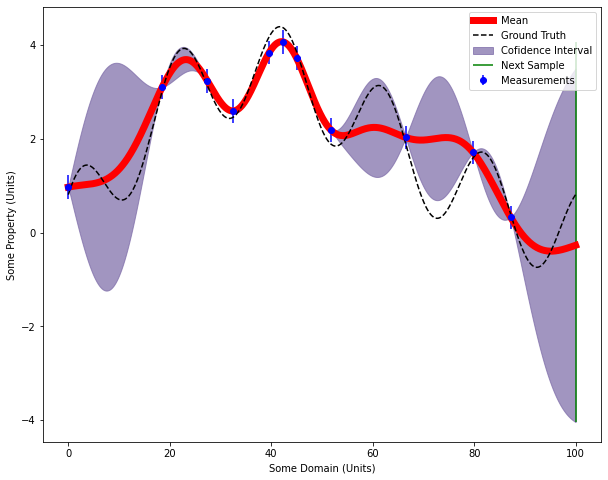

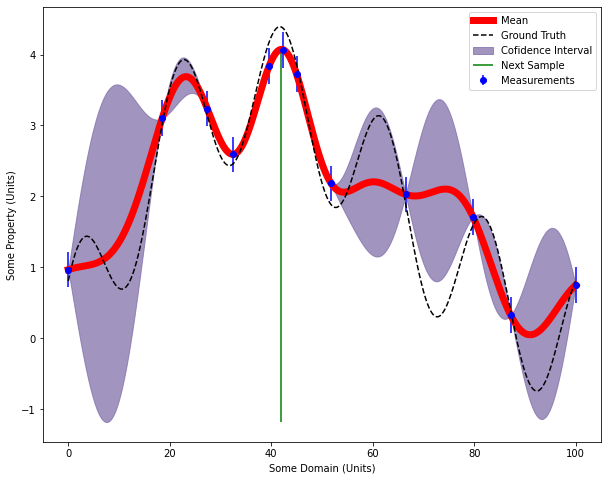

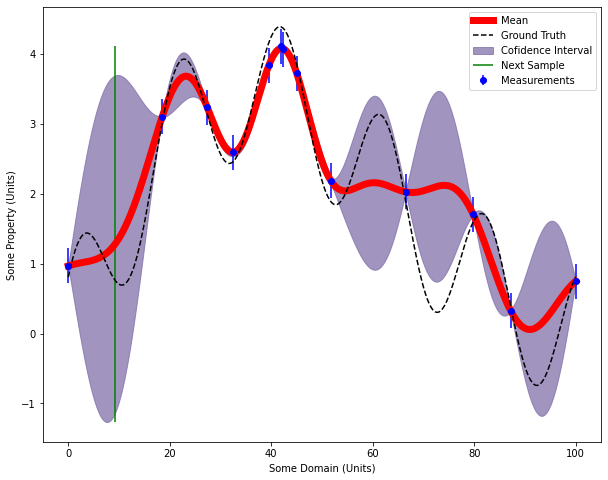

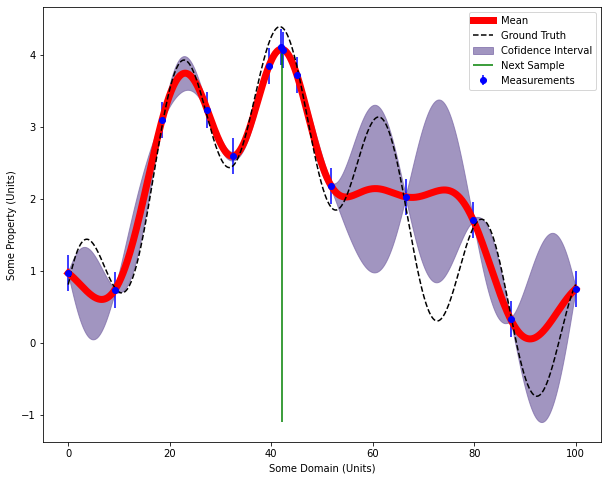

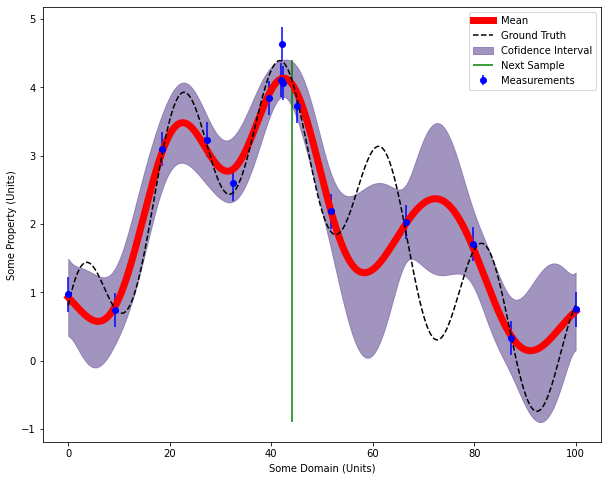

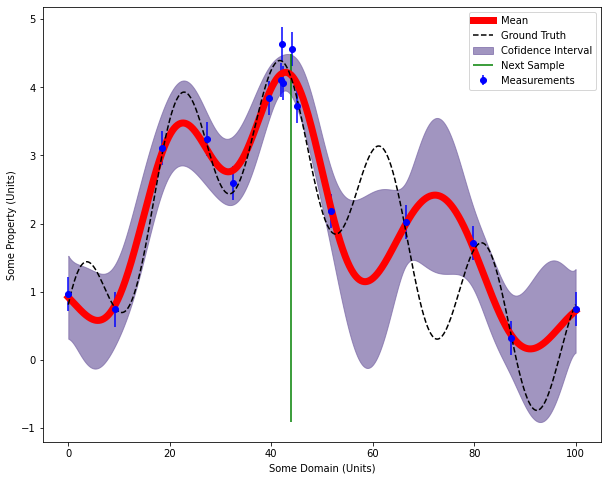

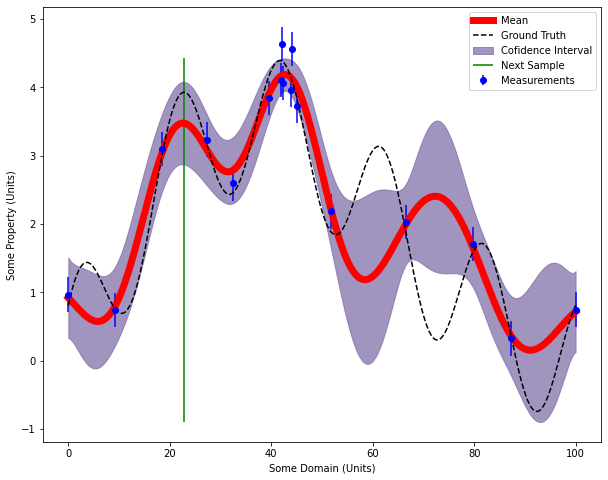

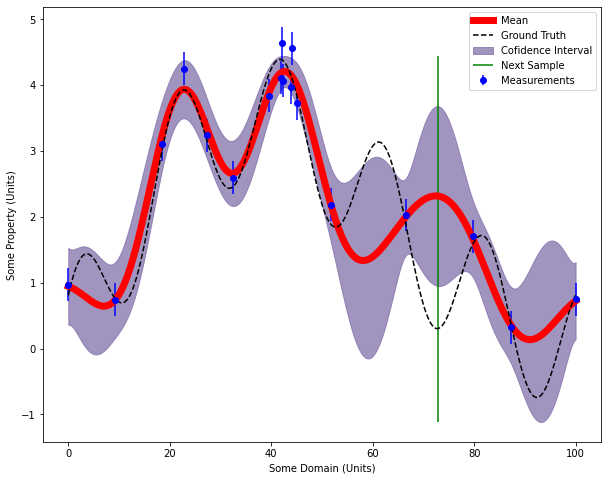

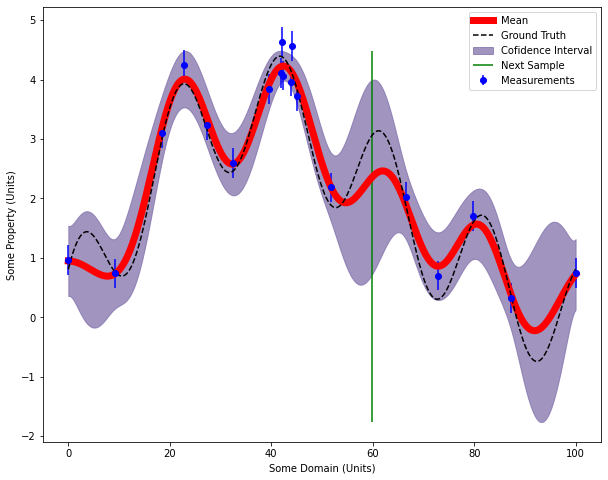

In [ ]:
#Initialize:
x_measured = x_starting
y_measured, y_measured_err = measure(x_measured)

#Active Learning Loops
for i in range(AL_loops):
  #Use a GP to analyze current data:
  model = Train_GPR(x_measured, y_measured)

  #Predict on ALL x locations:
  mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

  #Predict on unmeasured x locations:
  x_unmeasured = np.setdiff1d(x_test, x_measured)
  mean_unmeasured, var_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)))

  #Choose the next measurement:
  next= expected_improvement(mean_unmeasured, var_unmeasured, y_measured)
  x_next = x_unmeasured[next]  
  
  #plot
  y_upperbound = tf.reshape(mean, -1) +1.96*np.sqrt(var[:,0])
  y_lowerbound = tf.reshape(mean, -1) -1.96*np.sqrt(var[:,0])
  plt.figure(figsize=(10,8))
  plt.plot(x_test, mean, "r-", linewidth=7.0, label = 'Mean')
  plt.fill_between(tf.reshape(x_test, -1), 
                   y_upperbound, 
                   y_lowerbound, 
                   alpha=0.7, color="#7A68A6", label = 'Cofidence Interval')
  plt.errorbar(x_measured, y_measured, y_measured_err, fmt = "bo", label = "Measurements")
  plt.plot(x_ground_truth,y_ground_truth, "k--", label = "Ground Truth")
  plt.vlines(x_next, ymin= np.min(y_lowerbound), ymax = np.max(y_upperbound), colors='g', label = 'Next Sample')
  plt.xlabel("Some Domain (Units)")
  plt.ylabel("Some Property (Units)")
  plt.legend()
  plt.plot()  
  plt.show()

  #Measure the new locations and add that to the training data
  y_next, y_next_err = measure(x_next)
  y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
  x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
  

# Now let's compare some ative learning campaigns

Let's define some performance metrics 

Minimum Regret is a good metric if the goal was to find the opimum value.

In [ ]:
def minimum_regret(results):
  learning_curves = []

  true_best_y = np.max(y_ground_truth)

  num_runs = results['Bench_run'].max() + 1
  num_loops = results['AL_loop'].max() + 1
  for b in range(num_runs):
    run_results = results[results['Bench_run']==b]

    min_regret = []
    for i in range(num_loops):
      loop_result = run_results[run_results['AL_loop']==i]
      y_measured = loop_result['y_measured'].to_numpy()
      y_max = np.max(y_measured[0])
      min_regret.append(true_best_y - y_max)

    learning_curves.append(min_regret)

  return np.array(learning_curves)







Mean Square Error is a good metric if the goal is to learn the function accross the whole domain

In [ ]:
def mean_square_error(results):
  learning_curves = []

  num_runs = results['Bench_run'].max() + 1
  num_loops = results['AL_loop'].max() + 1
  for b in range(num_runs):
    run_results = results[results['Bench_run']==b]

    mse = []
    for i in range(num_loops):
      loop_result = run_results[run_results['AL_loop']==i]
      y_predict = loop_result['mean'].to_numpy()

      y_diff = y_predict[0].numpy().flatten()-y_ground_truth
      y_mean_square_error = np.sum((y_diff)**2)/len(y_ground_truth)
      mse.append(y_mean_square_error)
    learning_curves.append(mse)

  return np.array(learning_curves)

## First let's try the pure exploit

In [ ]:
Bench_runs = 10
AL_loops = 11

Pure_exploit_results = pd.DataFrame(columns = ['Bench_run', 
                                              'AL_loop',
                                              'x_measured',
                                              'y_measured',
                                              'mean',
                                              'var'])
j=0
for b in range(Bench_runs):
  #Initialize:
  starting_measurements = 5
  x_measured = np.random.permutation(x_test)[:starting_measurements]
  y_measured, y_measured_err = measure(x_measured)

  for i in range(AL_loops):
    #Use a GP to analyze current data:
    model = Train_GPR(x_measured, y_measured)

    #Predict on ALL x locations:
    mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

    #Store the results:
    Pure_exploit_results.loc[j,'Bench_run'] = b
    Pure_exploit_results.loc[j,'AL_loop'] = i
    Pure_exploit_results.loc[j,'x_measured'] = x_measured
    Pure_exploit_results.loc[j,'y_measured'] = y_measured
    Pure_exploit_results.loc[j,'mean'] = mean
    Pure_exploit_results.loc[j,'var'] = var
    

    #Predict on unmeasured x locations:
    x_unmeasured = np.setdiff1d(x_test, x_measured)
    mean_unmeasured, var_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)))

    #Choose the next measurement:
    next= pure_exploit(mean_unmeasured, var_unmeasured)
    x_next = x_unmeasured[next]  

    #Measure the new locations and add that to the training data
    y_next, y_next_err = measure(x_next)
    y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
    x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
    
    #index
    j+=1


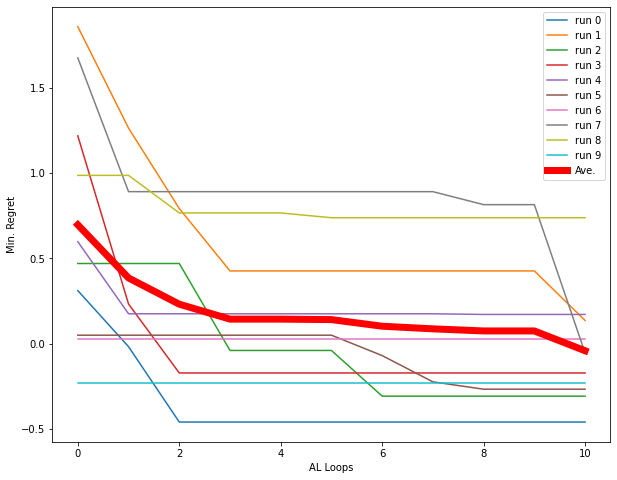

In [ ]:
min_regret_pure_exploit = minimum_regret(Pure_exploit_results)

average_min_regret_pe = np.mean(min_regret_pure_exploit, axis = 0)

runs = np.arange(min_regret_pure_exploit.shape[0])
loops = np.arange(min_regret_pure_exploit.shape[1])
plt.figure(figsize=(10,8))
for r in runs:
  plt.plot(loops, min_regret_pure_exploit[r,:], label = f"run {r}")
plt.plot(loops, average_min_regret_pe,'r-', linewidth=7.0,label = 'Ave.')
plt.xlabel("AL Loops")
plt.ylabel("Min. Regret")
plt.legend()
plt.plot()  
plt.show()

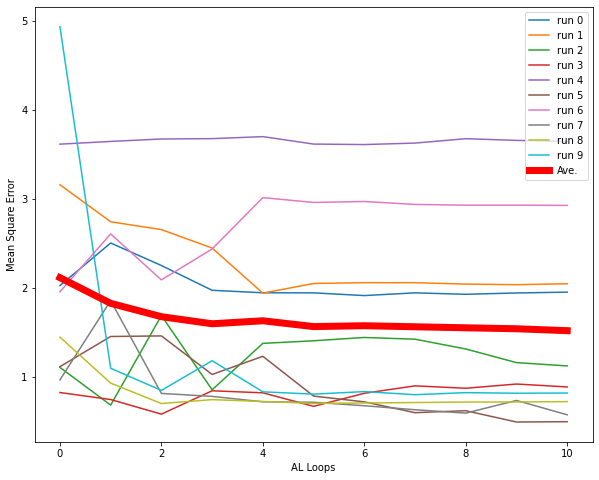

In [ ]:
mse_pure_exploit = mean_square_error(Pure_exploit_results)

average_mse_pe = np.mean(mse_pure_exploit, axis = 0)

runs = np.arange(mse_pure_exploit.shape[0])
loops = np.arange(mse_pure_exploit.shape[1])
plt.figure(figsize=(10,8))
for r in runs:
  plt.plot(loops, mse_pure_exploit[r,:], label = f"run {r}")
plt.plot(loops, average_mse_pe,'r-', linewidth=7.0,label = 'Ave.')
plt.xlabel("AL Loops")
plt.ylabel("Mean Square Error")
plt.legend()
plt.plot()  
plt.show()

## Now let's try Pure Explore

In [ ]:
Bench_runs = 10
AL_loops = 11

Pure_explore_results = pd.DataFrame(columns = ['Bench_run', 
                                              'AL_loop',
                                              'x_measured',
                                              'y_measured',
                                              'mean',
                                              'var'])
j=0
for b in range(Bench_runs):
  #Initialize:
  starting_measurements = 5
  x_measured = np.random.permutation(x_test)[:starting_measurements]
  y_measured, y_measured_err = measure(x_measured)

  for i in range(AL_loops):
    #Use a GP to analyze current data:
    model = Train_GPR(x_measured, y_measured)

    #Predict on ALL x locations:
    mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

    #Store the results:
    Pure_explore_results.loc[j,'Bench_run'] = b
    Pure_explore_results.loc[j,'AL_loop'] = i
    Pure_explore_results.loc[j,'x_measured'] = x_measured
    Pure_explore_results.loc[j,'y_measured'] = y_measured
    Pure_explore_results.loc[j,'mean'] = mean
    Pure_explore_results.loc[j,'var'] = var
    

    #Predict on unmeasured x locations:
    x_unmeasured = np.setdiff1d(x_test, x_measured)
    mean_unmeasured, var_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)))

    #Choose the next measurement:
    next= pure_explore(mean_unmeasured, var_unmeasured)
    x_next = x_unmeasured[next]  

    #Measure the new locations and add that to the training data
    y_next, y_next_err = measure(x_next)
    y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
    x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
    
    #index
    j+=1


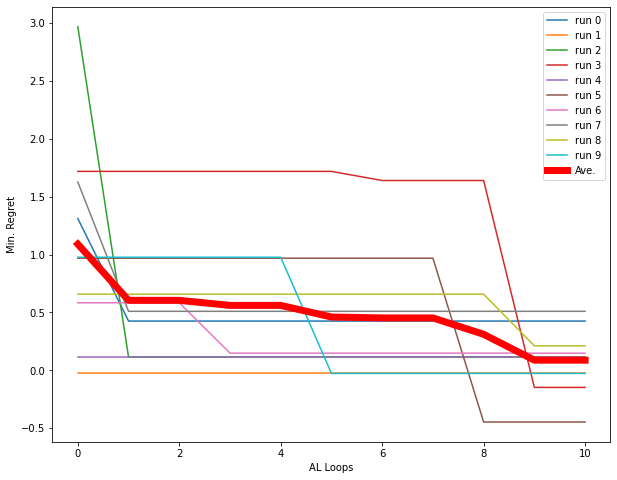

In [ ]:
min_regret_pure_explore = minimum_regret(Pure_explore_results)

average_min_regret_pexplore = np.mean(min_regret_pure_explore, axis = 0)

runs = np.arange(min_regret_pure_explore.shape[0])
loops = np.arange(min_regret_pure_explore.shape[1])
plt.figure(figsize=(10,8))
for r in runs:
  plt.plot(loops, min_regret_pure_explore[r,:], label = f"run {r}")
plt.plot(loops, average_min_regret_pexplore,'r-', linewidth=7.0,label = 'Ave.')
plt.xlabel("AL Loops")
plt.ylabel("Min. Regret")
plt.legend()
plt.plot()  
plt.show()

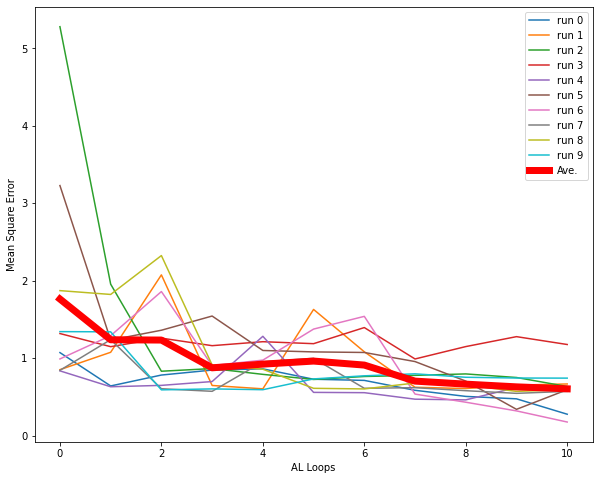

In [ ]:
mse_pure_explore = mean_square_error(Pure_explore_results)

average_mse_pexplore = np.mean(mse_pure_explore, axis = 0)

runs = np.arange(mse_pure_explore.shape[0])
loops = np.arange(mse_pure_explore.shape[1])
plt.figure(figsize=(10,8))
for r in runs:
  plt.plot(loops, mse_pure_explore[r,:], label = f"run {r}")
plt.plot(loops, average_mse_pexplore,'r-', linewidth=7.0,label = 'Ave.')
plt.xlabel("AL Loops")
plt.ylabel("Mean Square Error")
plt.legend()
plt.plot()  
plt.show()

## Upper Confidence Bounds

In [ ]:
Bench_runs = 10
AL_loops = 11

UCB_results = pd.DataFrame(columns = ['Bench_run', 
                                              'AL_loop',
                                              'x_measured',
                                              'y_measured',
                                              'mean',
                                              'var'])
j=0
for b in range(Bench_runs):
  #Initialize:
  starting_measurements = 5
  x_measured = np.random.permutation(x_test)[:starting_measurements]
  y_measured, y_measured_err = measure(x_measured)

  for i in range(AL_loops):
    #Use a GP to analyze current data:
    model = Train_GPR(x_measured, y_measured)

    #Predict on ALL x locations:
    mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

    #Store the results:
    UCB_results.loc[j,'Bench_run'] = b
    UCB_results.loc[j,'AL_loop'] = i
    UCB_results.loc[j,'x_measured'] = x_measured
    UCB_results.loc[j,'y_measured'] = y_measured
    UCB_results.loc[j,'mean'] = mean
    UCB_results.loc[j,'var'] = var
    

    #Predict on unmeasured x locations:
    x_unmeasured = np.setdiff1d(x_test, x_measured)
    mean_unmeasured, var_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)))

    #Choose the next measurement:
    next= upper_confedence_bound(mean_unmeasured, var_unmeasured)
    x_next = x_unmeasured[next]  

    #Measure the new locations and add that to the training data
    y_next, y_next_err = measure(x_next)
    y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
    x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
    
    #index
    j+=1


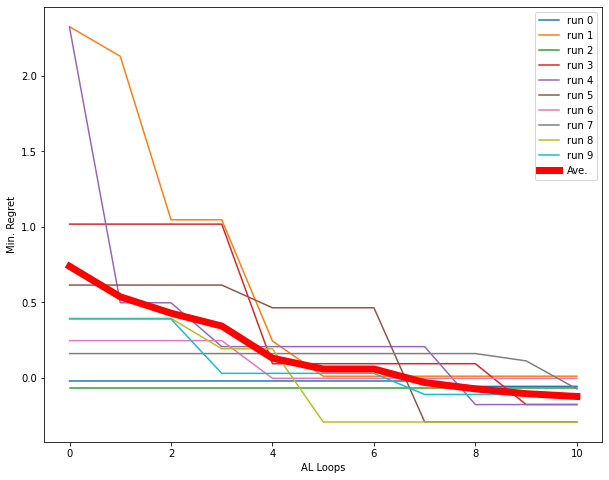

In [ ]:
min_regret_ucb = minimum_regret(UCB_results)

average_min_regret_ucb = np.mean(min_regret_ucb, axis = 0)

runs = np.arange(min_regret_ucb.shape[0])
loops = np.arange(min_regret_ucb.shape[1])
plt.figure(figsize=(10,8))
for r in runs:
  plt.plot(loops, min_regret_ucb[r,:], label = f"run {r}")
plt.plot(loops, average_min_regret_ucb,'r-', linewidth=7.0,label = 'Ave.')
plt.xlabel("AL Loops")
plt.ylabel("Min. Regret")
plt.legend()
plt.plot()  
plt.show()

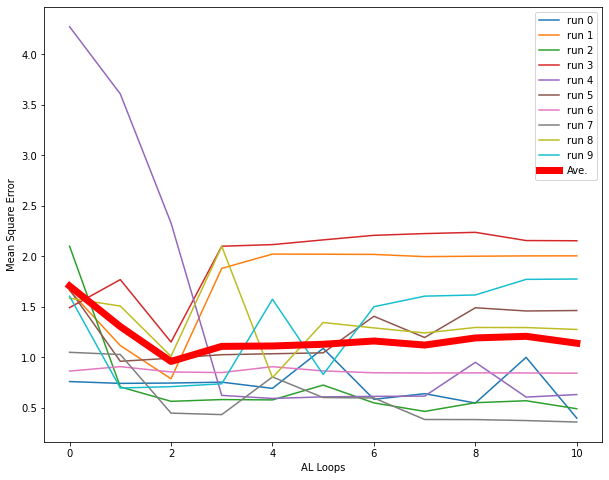

In [ ]:
mse_ucb = mean_square_error(UCB_results)

average_mse_ucb = np.mean(mse_ucb, axis = 0)

runs = np.arange(mse_ucb.shape[0])
loops = np.arange(mse_ucb.shape[1])
plt.figure(figsize=(10,8))
for r in runs:
  plt.plot(loops, mse_ucb[r,:], label = f"run {r}")
plt.plot(loops, average_mse_ucb,'r-', linewidth=7.0,label = 'Ave.')
plt.xlabel("AL Loops")
plt.ylabel("Mean Square Error")
plt.legend()
plt.plot()  
plt.show()

## Finially Expected Improvement

In [ ]:
Bench_runs = 10
AL_loops = 11

Expected_improvement_results = pd.DataFrame(columns = ['Bench_run', 
                                              'AL_loop',
                                              'x_measured',
                                              'y_measured',
                                              'mean',
                                              'var'])
j=0
for b in range(Bench_runs):
  #Initialize:
  starting_measurements = 5
  x_measured = np.random.permutation(x_test)[:starting_measurements]
  y_measured, y_measured_err = measure(x_measured)

  for i in range(AL_loops):
    #Use a GP to analyze current data:
    model = Train_GPR(x_measured, y_measured)

    #Predict on ALL x locations:
    mean, var = model.predict_f(tf.convert_to_tensor(x_test.reshape(-1,1)))

    #Store the results:
    Expected_improvement_results.loc[j,'Bench_run'] = b
    Expected_improvement_results.loc[j,'AL_loop'] = i
    Expected_improvement_results.loc[j,'x_measured'] = x_measured
    Expected_improvement_results.loc[j,'y_measured'] = y_measured
    Expected_improvement_results.loc[j,'mean'] = mean
    Expected_improvement_results.loc[j,'var'] = var
    

    #Predict on unmeasured x locations:
    x_unmeasured = np.setdiff1d(x_test, x_measured)
    mean_unmeasured, var_unmeasured = model.predict_f(tf.convert_to_tensor(x_unmeasured.reshape(-1,1)))

    #Choose the next measurement:
    next= expected_improvement(mean_unmeasured, var_unmeasured, y_measured)
    x_next = x_unmeasured[next]  

    #Measure the new locations and add that to the training data
    y_next, y_next_err = measure(x_next)
    y_measured = np.concatenate((y_measured, y_next.reshape(-1)))
    x_measured = np.concatenate((x_measured, x_next.reshape(-1)))
    
    #index
    j+=1


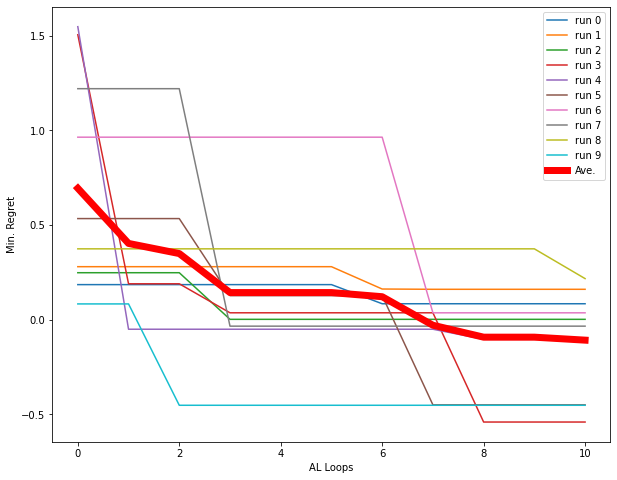

In [ ]:
min_regret_expected_improvement = minimum_regret(Expected_improvement_results)

average_min_regret_ei = np.mean(min_regret_expected_improvement, axis = 0)

runs = np.arange(min_regret_expected_improvement.shape[0])
loops = np.arange(min_regret_expected_improvement.shape[1])
plt.figure(figsize=(10,8))
for r in runs:
  plt.plot(loops, min_regret_expected_improvement[r,:], label = f"run {r}")
plt.plot(loops, average_min_regret_ei,'r-', linewidth=7.0,label = 'Ave.')
plt.xlabel("AL Loops")
plt.ylabel("Min. Regret")
plt.legend()
plt.plot()  
plt.show()

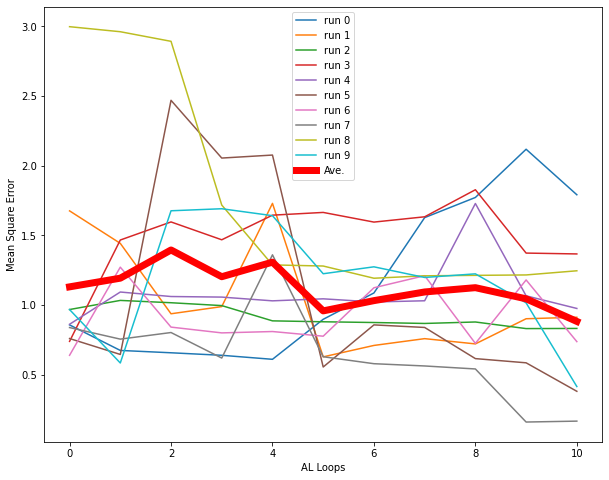

In [ ]:
mse_expected_improvement = mean_square_error(Expected_improvement_results)

average_mse_ei = np.mean(mse_expected_improvement, axis = 0)

runs = np.arange(mse_expected_improvement.shape[0])
loops = np.arange(mse_expected_improvement.shape[1])
plt.figure(figsize=(10,8))
for r in runs:
  plt.plot(loops, mse_expected_improvement[r,:], label = f"run {r}")
plt.plot(loops, average_mse_ei,'r-', linewidth=7.0,label = 'Ave.')
plt.xlabel("AL Loops")
plt.ylabel("Mean Square Error")
plt.legend()
plt.plot()  
plt.show()

## Now let's compare the Active Learning Strategies

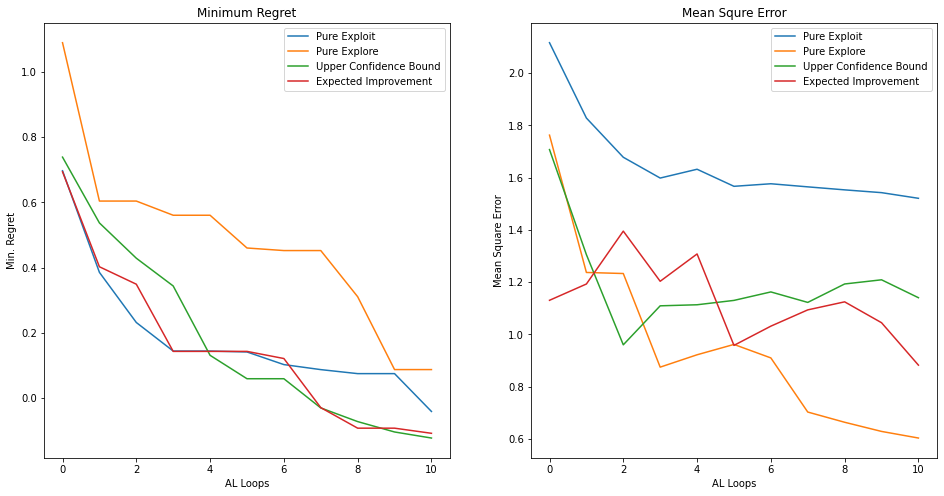

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Minimum Regret')
plt.plot(loops, average_min_regret_pe, label = 'Pure Exploit')
plt.plot(loops, average_min_regret_pexplore, label = 'Pure Explore')
plt.plot(loops, average_min_regret_ucb, label = 'Upper Confidence Bound')
plt.plot(loops, average_min_regret_ei, label = 'Expected Improvement')
plt.xlabel("AL Loops")
plt.ylabel("Min. Regret")
plt.legend()


plt.subplot(122)
plt.title('Mean Squre Error')
plt.plot(loops, average_mse_pe,label = 'Pure Exploit')
plt.plot(loops, average_mse_pexplore,label = 'Pure Explore')
plt.plot(loops, average_mse_ucb,label = 'Upper Confidence Bound')
plt.plot(loops, average_mse_ei,label = 'Expected Improvement')
plt.xlabel("AL Loops")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()